# Computational Health Informatics : Project II - Structured/Time-series Data Sets with ML

The aim of this project is to implement a machine learning algorithm process using open-datasets, such as MIT_BIH Arrhythmia for classification.  

The goal is to train 3 machine learning algorithms on the physiological data. During this project various Data Preparation, Cleaning, Processing, Transforming, Training and Testing procedures were implemented to better understand the scope of Machine Learning in Healthcare data analysis.

# MIT-BIH Arrhythmia Database

### Dataset overview:

The dataset consisted of 48 half-hour recordings of ECG signals from different subjects, with annotations marking each heartbeat type, along with a range of arrhythmias. The excerpts consists of two-channel ambulatory ECG recordings, where channel 1 corresponds to ML II (Lead II), a common ECG lead. It runs from the right arm to the left leg and is highly sensitive for detecting arrhythmias

The dataset includes annotations indicating different types of heartbeats or arrhythmias. There are about 109,000 heartbeats across all recordings, annotated with labels indicating normal beats, ventricular ectopic beats, supraventricular ectopic beats, fusion beats, and other arrhythmic conditions.

Some arrhythmia types are much less frequent, leading to class imbalance, which can impact classifier performance and necessitate special techniques, like synthetic data generation or resampling.


### Data Import

The MIT-BIH Arrhythmia Database import process involves several steps, as the data is stored as raw ECG signal recordings. Therefore, the raw signals have to be interpreted and prepared for analysis. 

To handle and preprocess the ECG signals, typically libraries like wfdb (WaveForm Database library), numpy for numerical operations, and pandas to organize data into DataFrames were used.

In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, welch
import matplotlib.pyplot as plt


# Define the dataset directory and rhythm table
dataset_dir = r'C:\\Users\\shiva\\My Usage\\MS Coursework\\Sem3\\CHI\\Assignments\\HW2\\mit-bih-arrhythmia-database-1.0.0'


Each ECG record (e.g., '100', '101') in the dataset is stored as two main files: a signal file (.dat) and an annotation file (.atr).
Using wfdb,the signals and annotations from each file were loaded. The ECG signal will look like below,

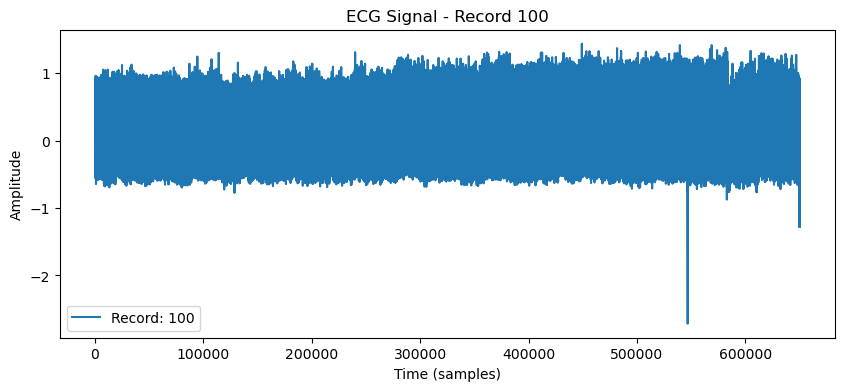

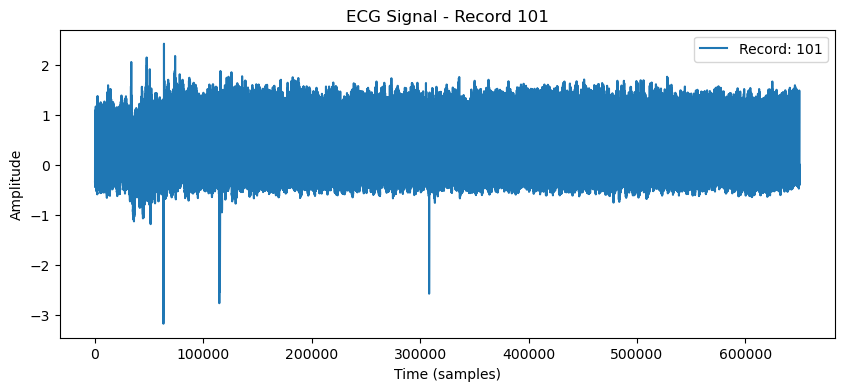

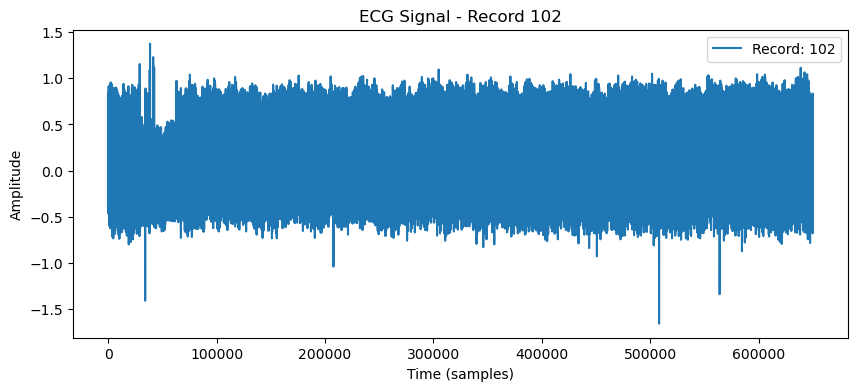

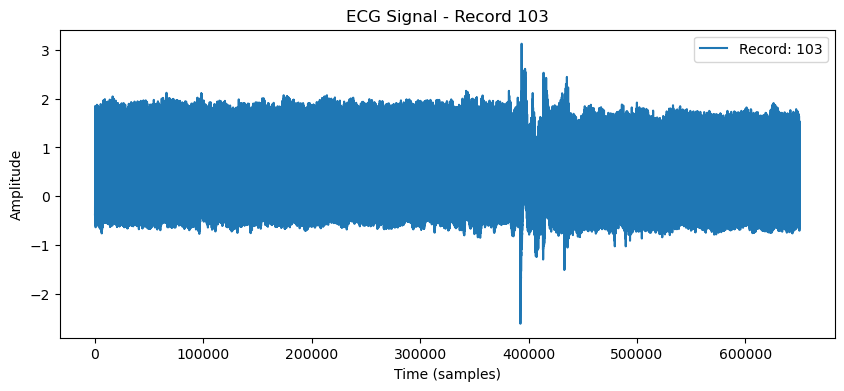

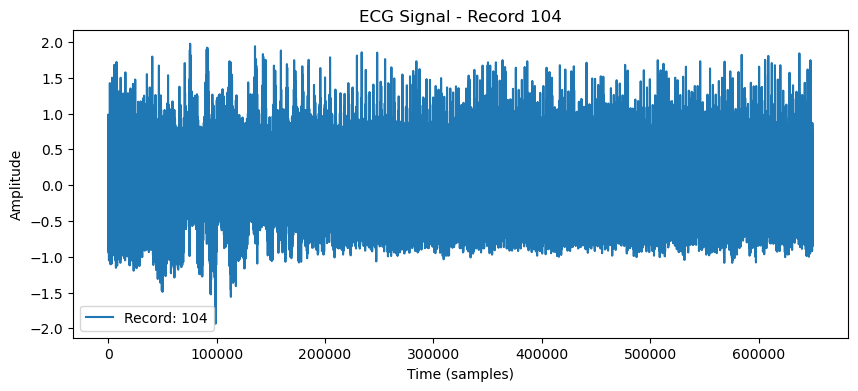

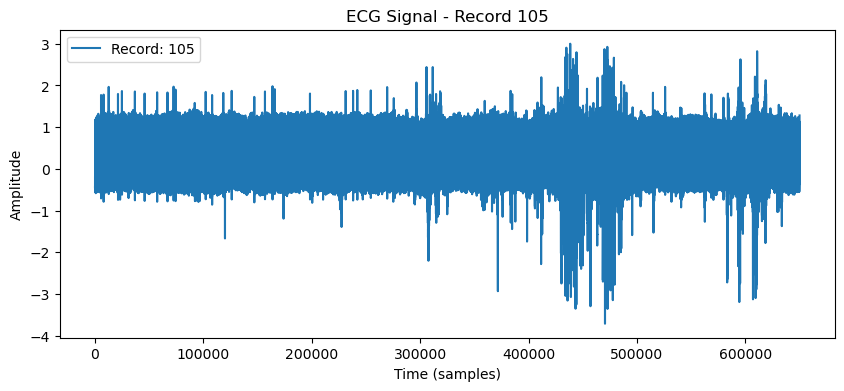

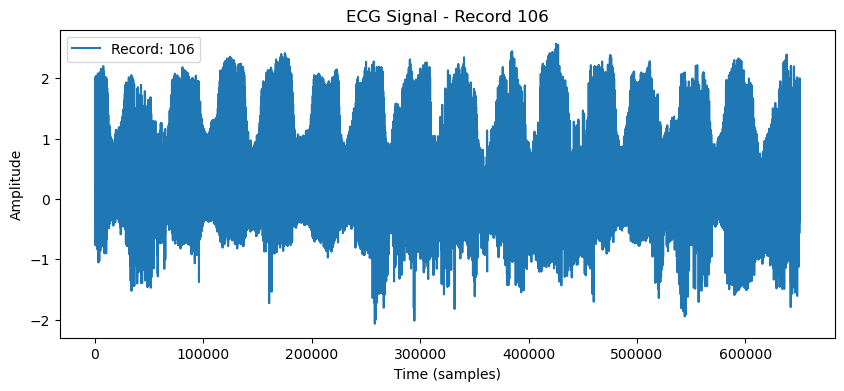

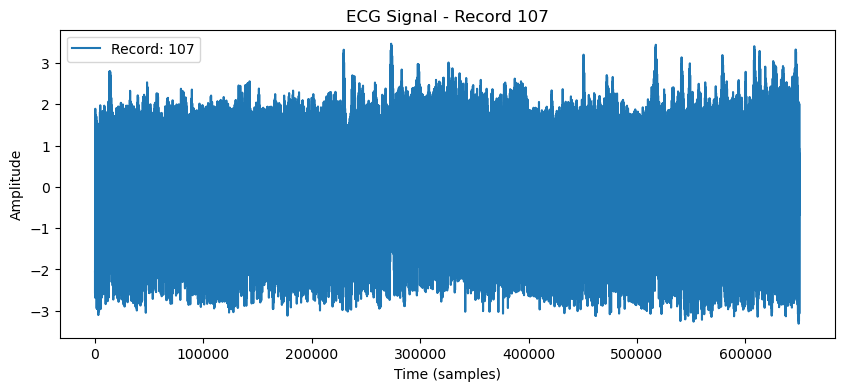

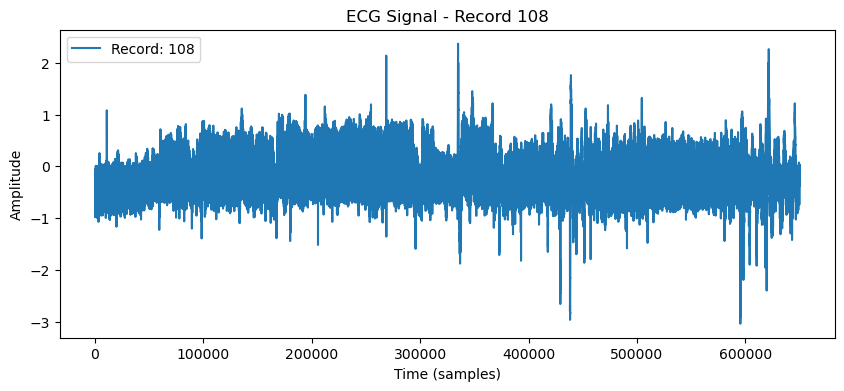

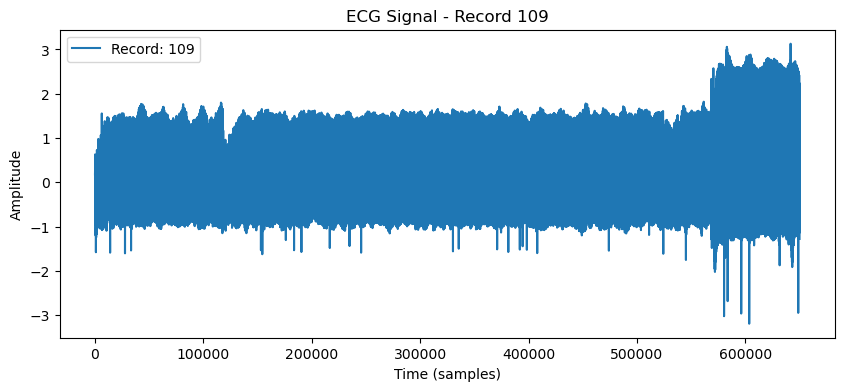

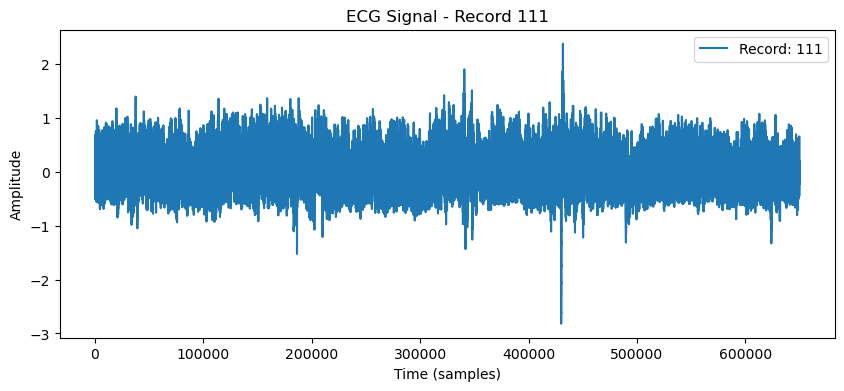

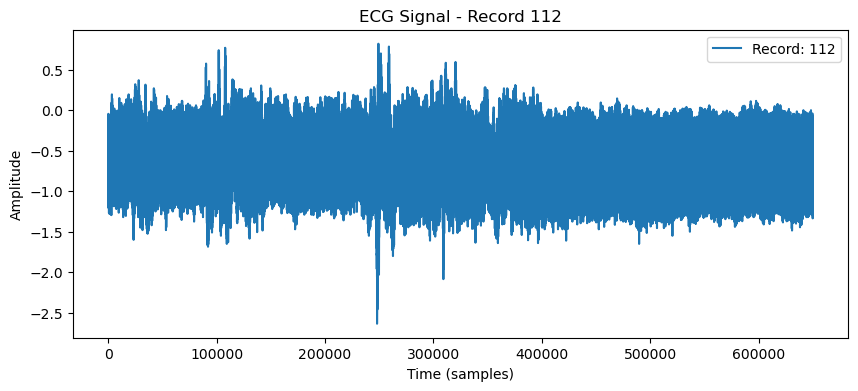

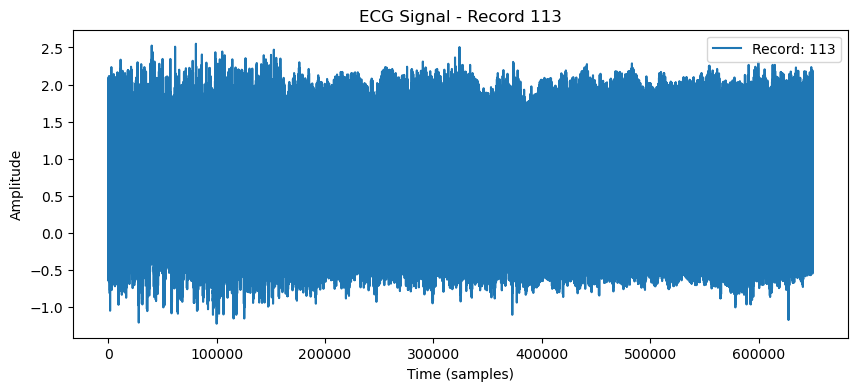

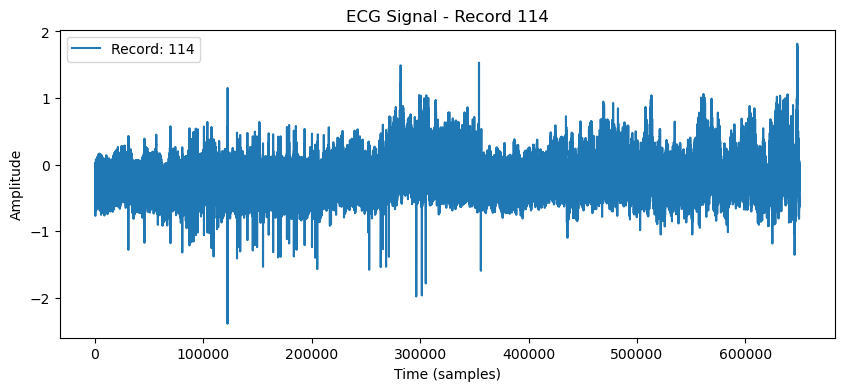

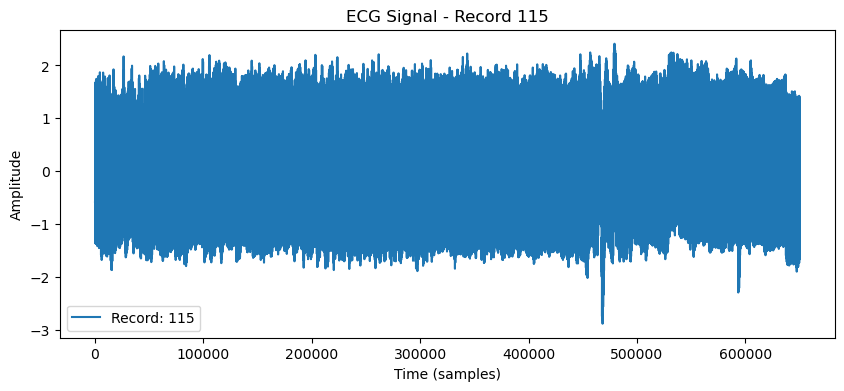

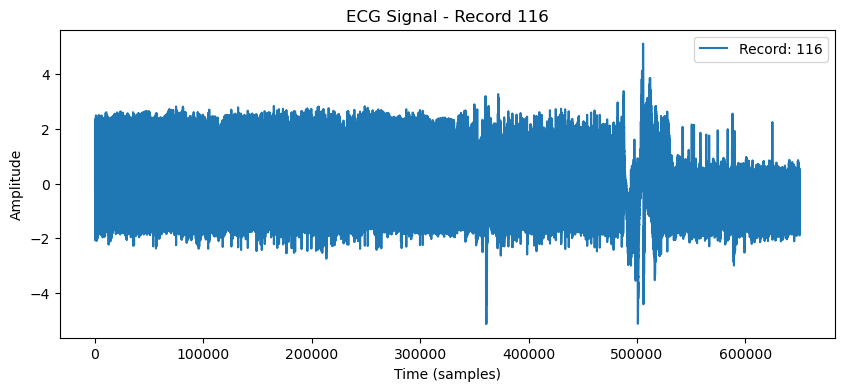

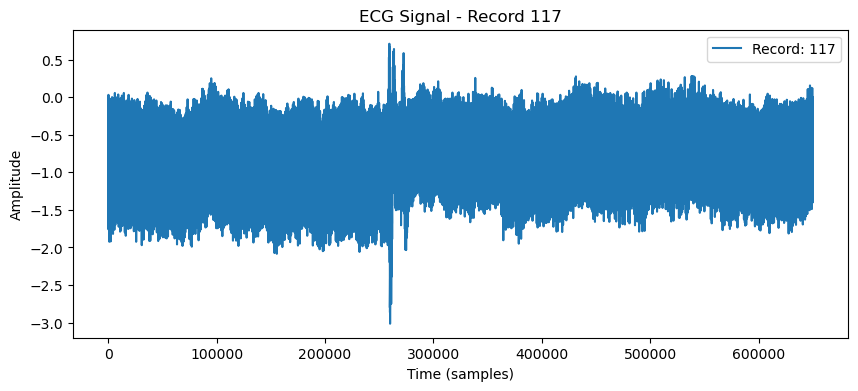

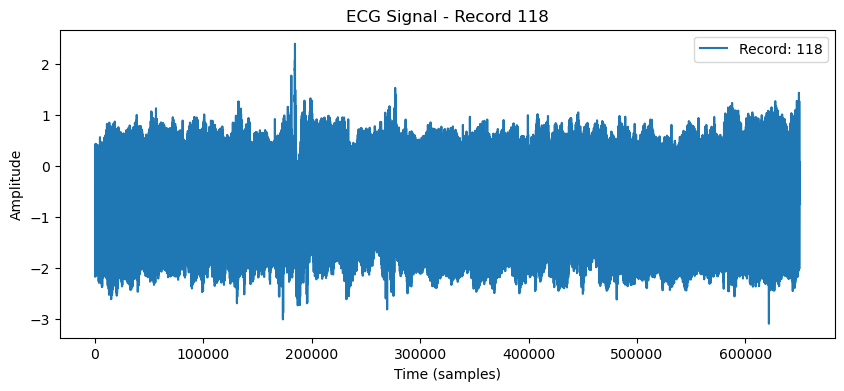

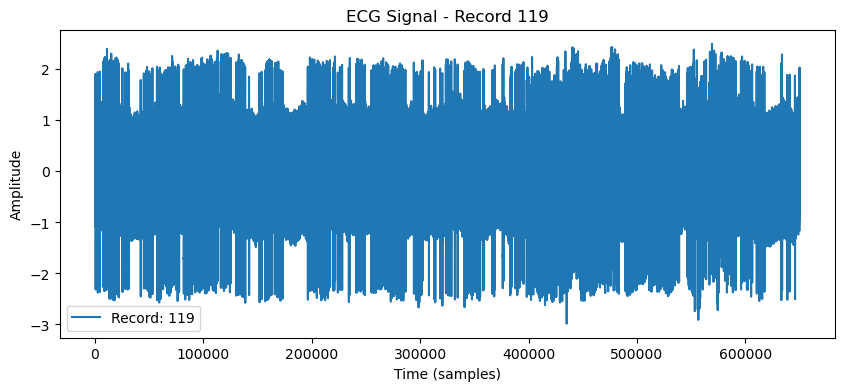

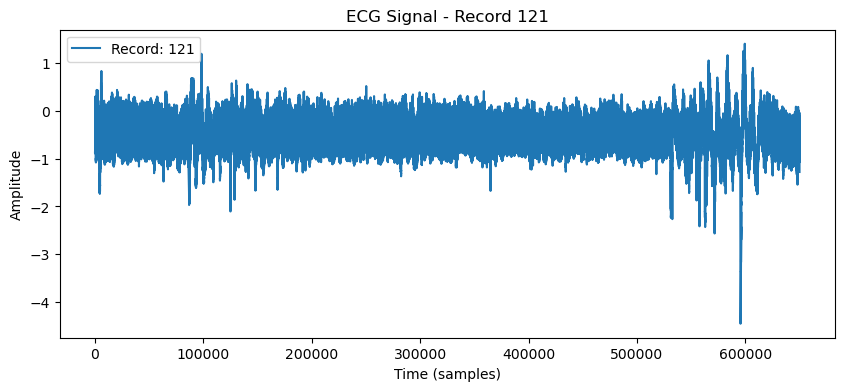

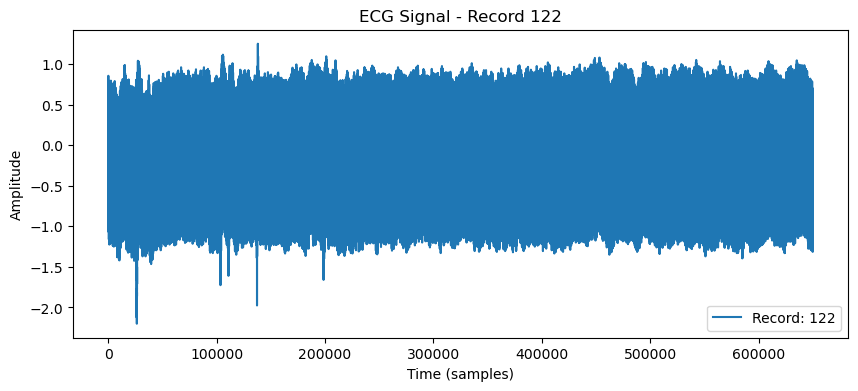

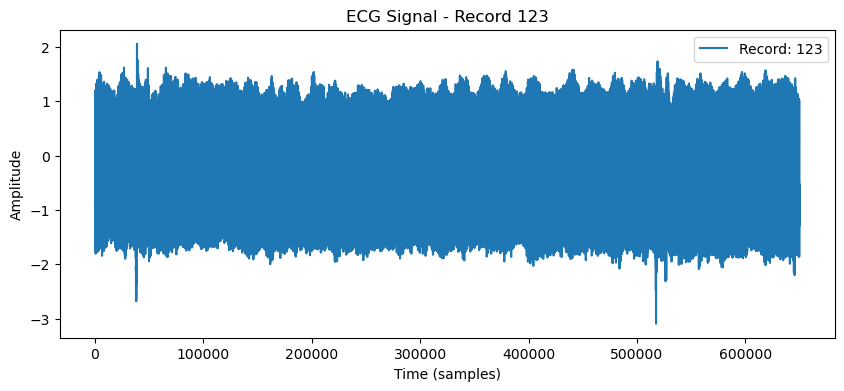

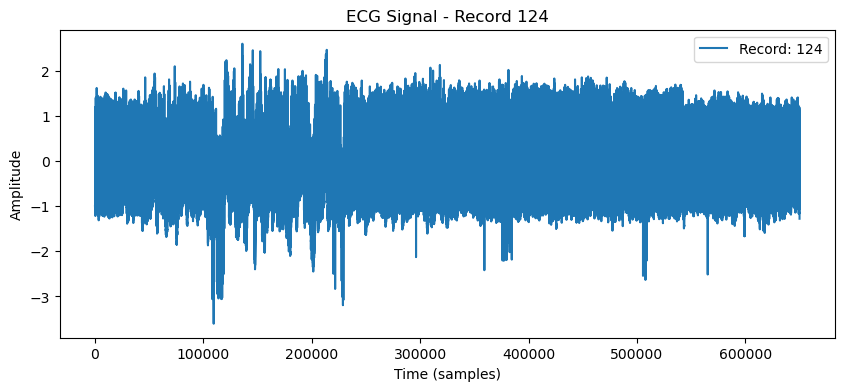

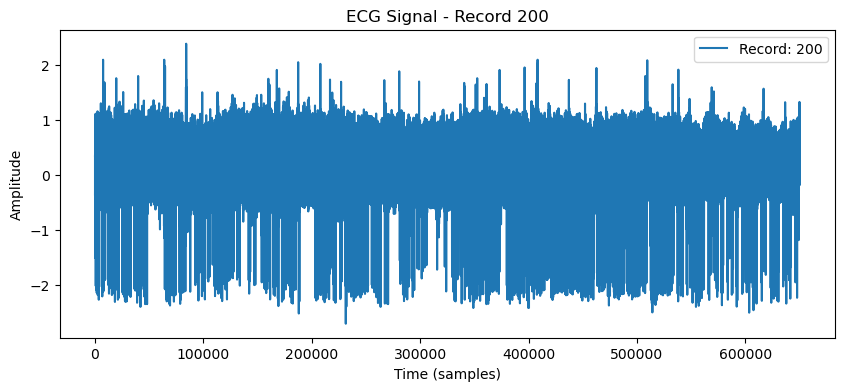

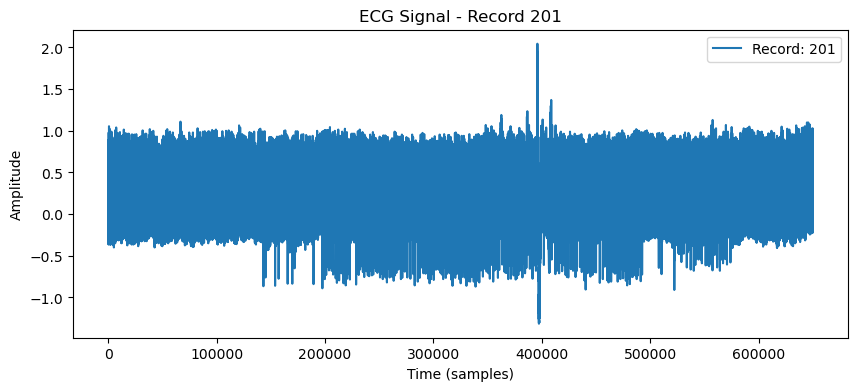

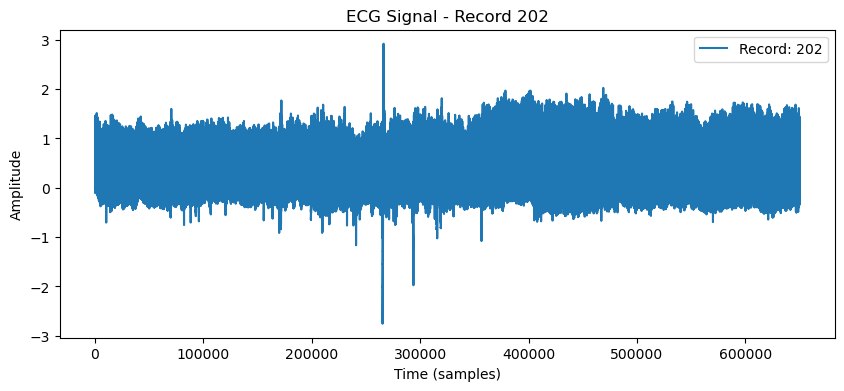

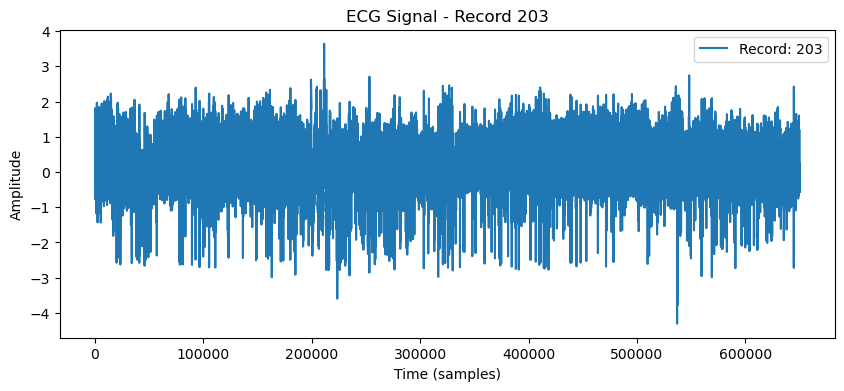

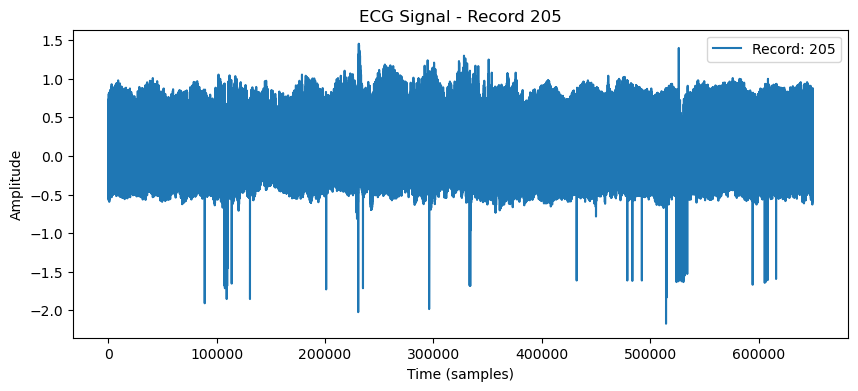

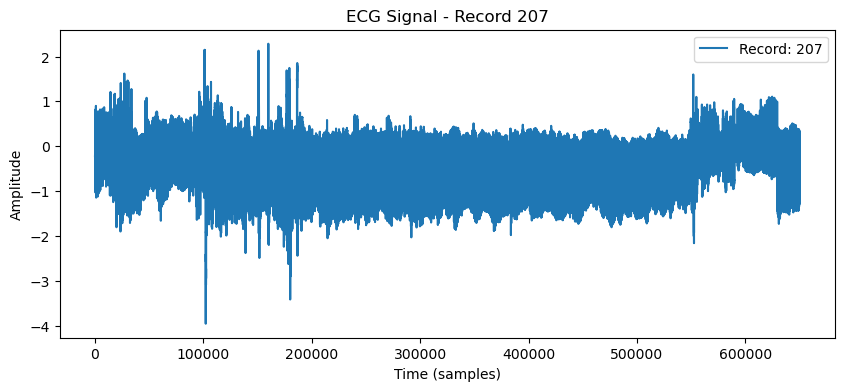

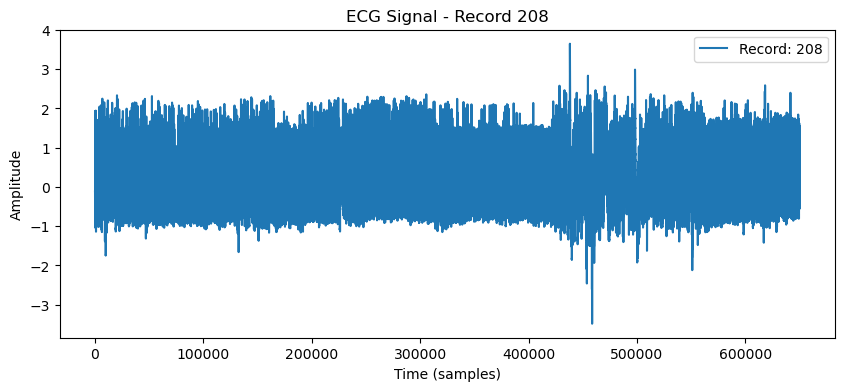

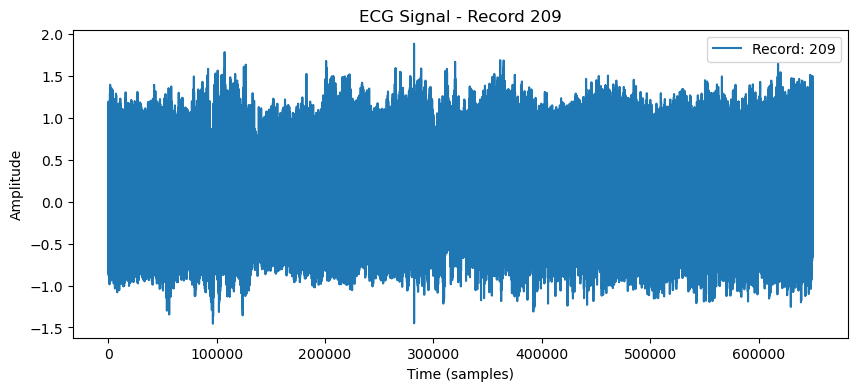

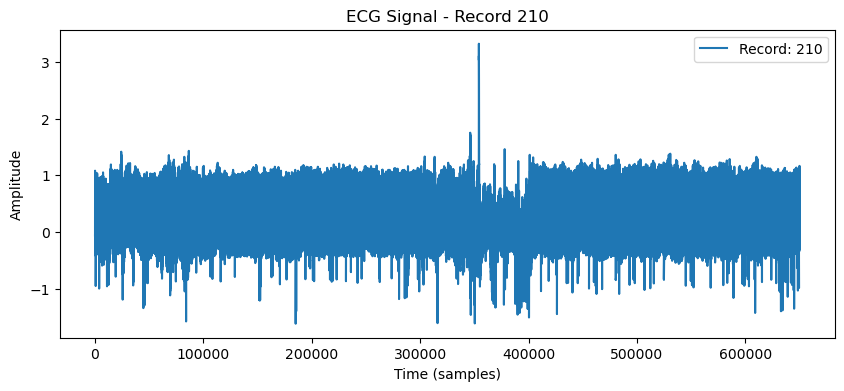

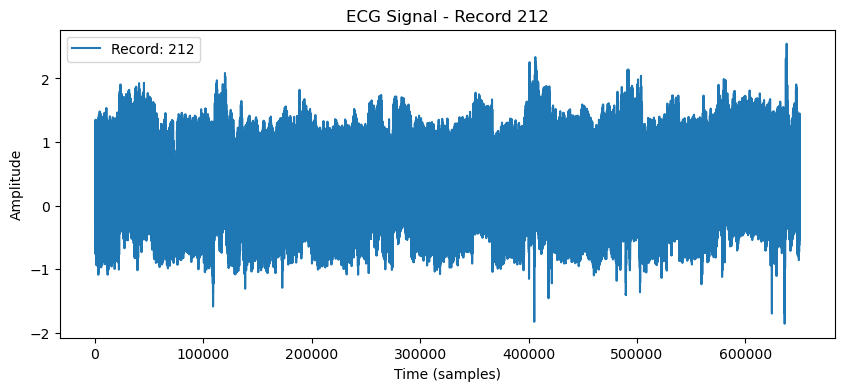

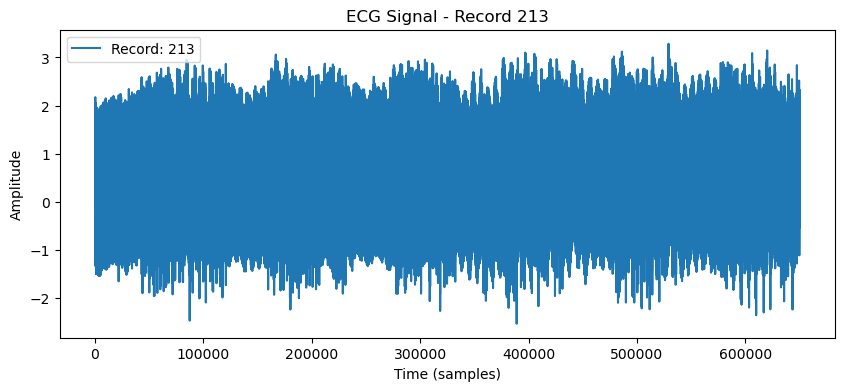

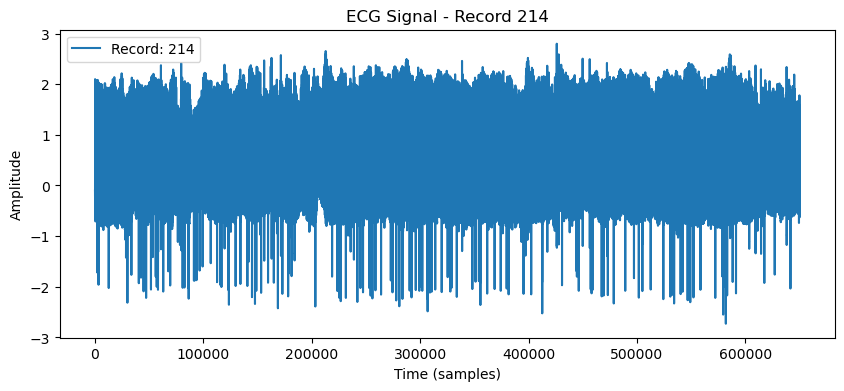

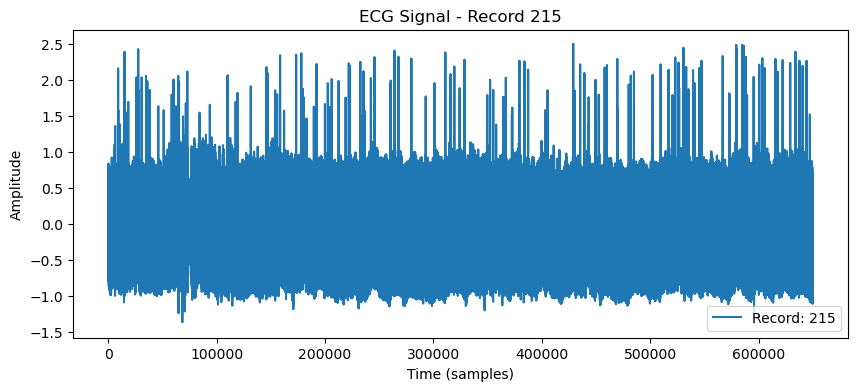

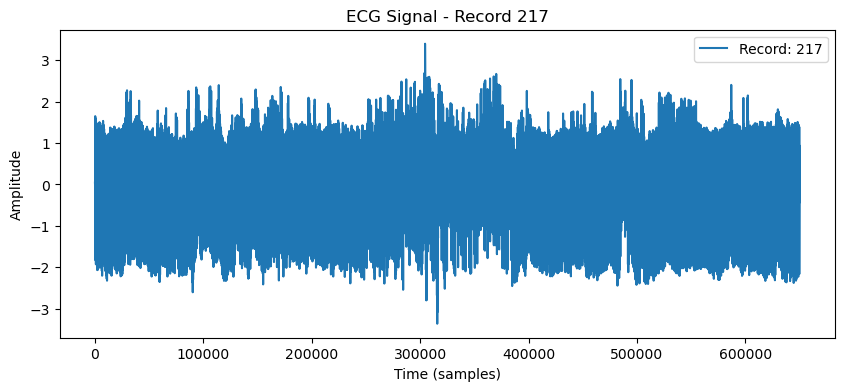

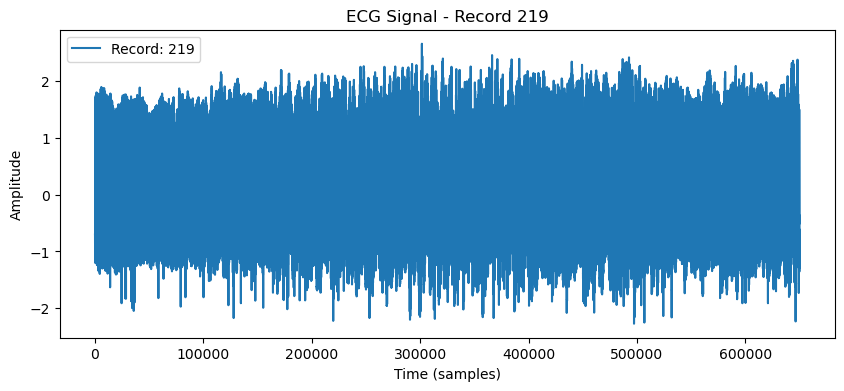

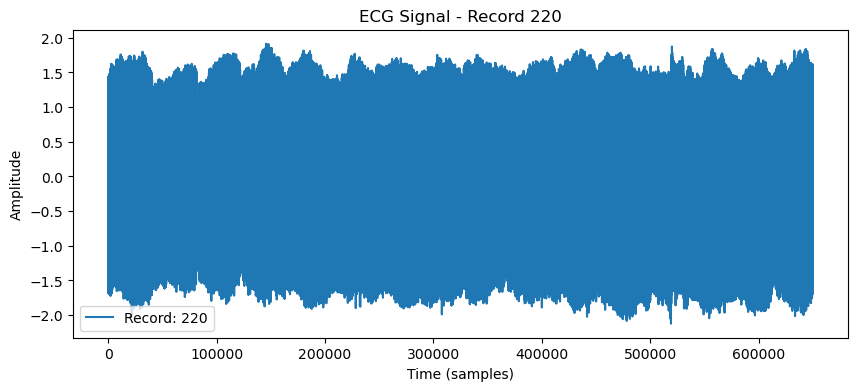

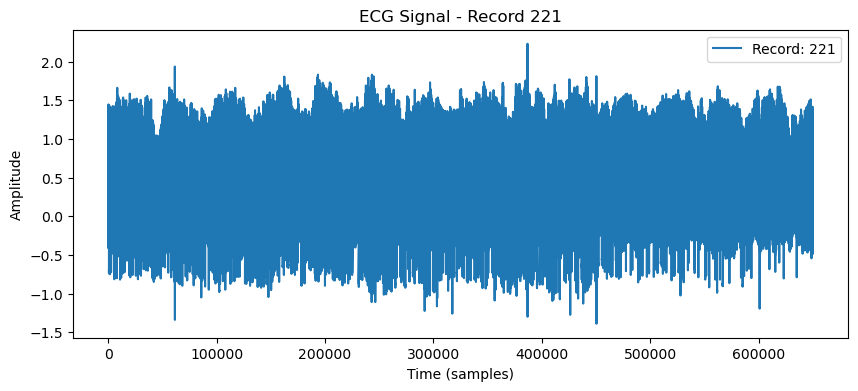

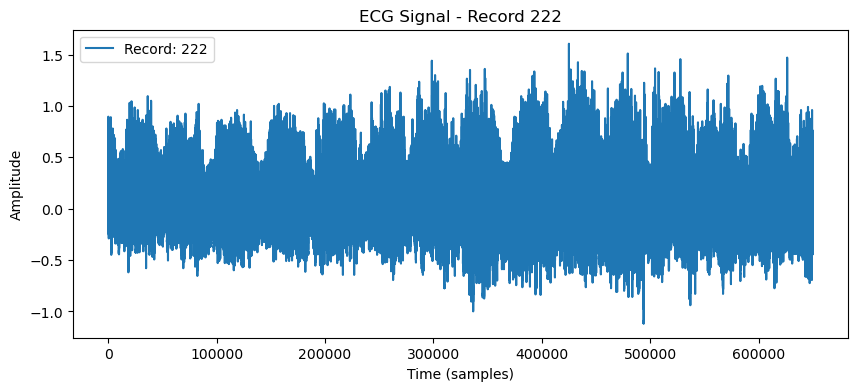

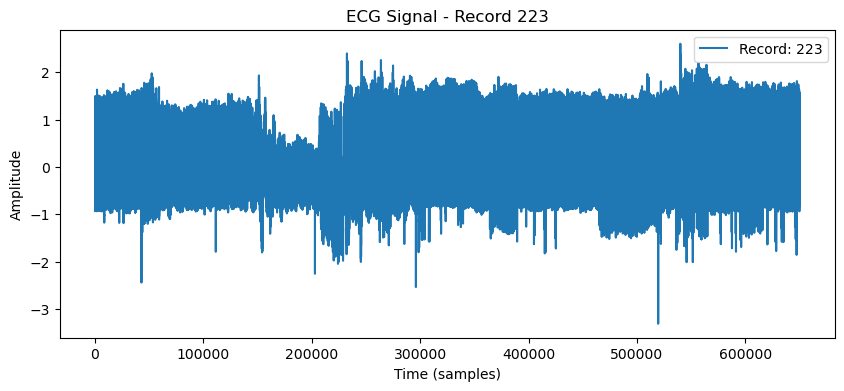

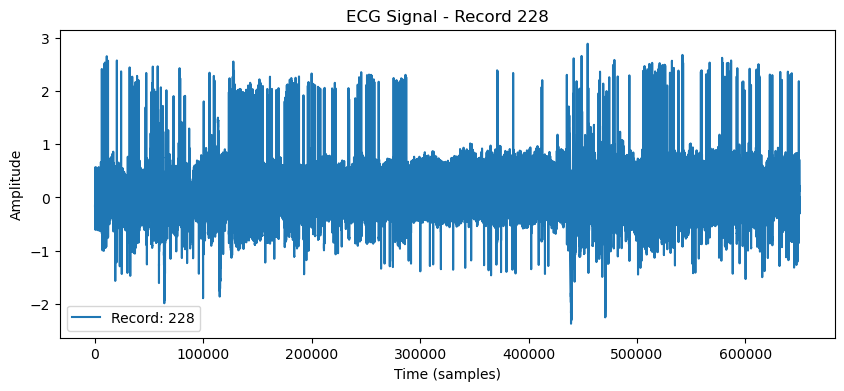

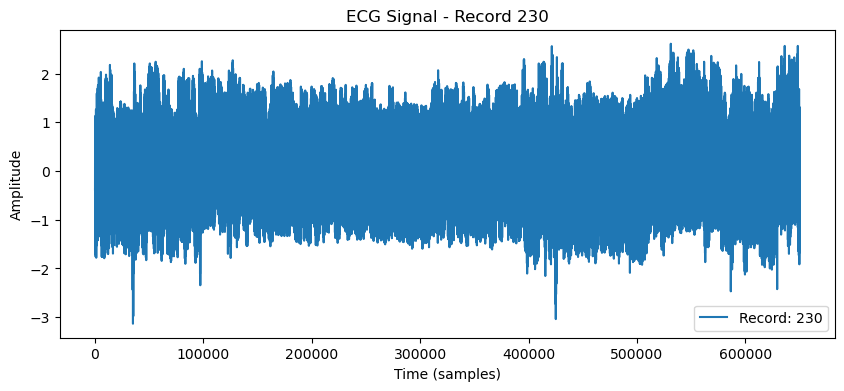

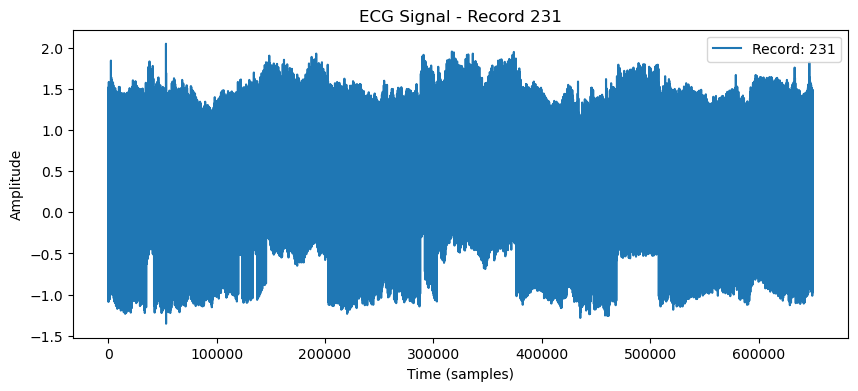

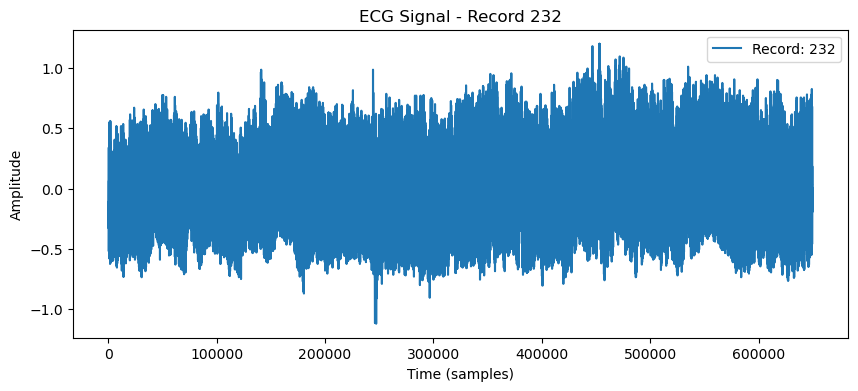

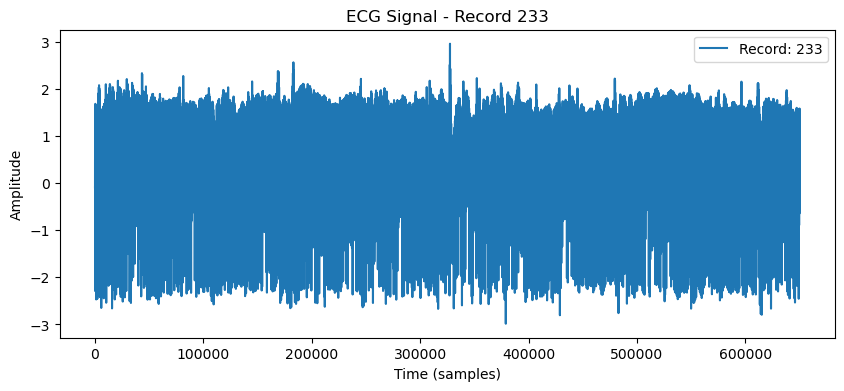

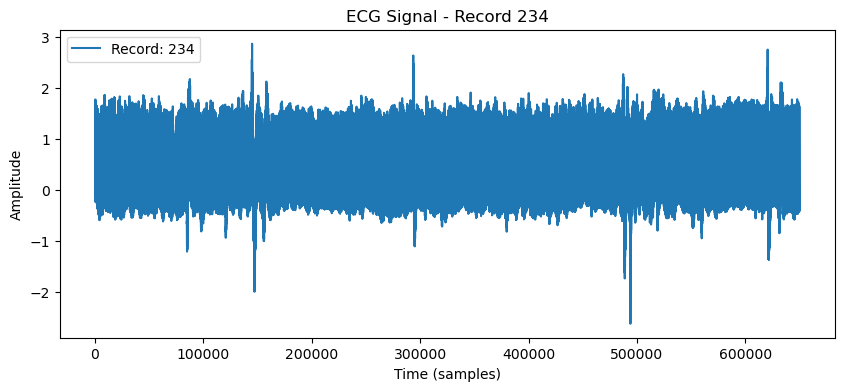

In [2]:
# Path to dataset
data_path = "C:\\Users\\shiva\\My Usage\\MS Coursework\\Sem3\\CHI\\Assignments\\HW2\\mit-bih-arrhythmia-database-1.0.0"

# List all record files
record_files = [f for f in os.listdir(data_path) if f.endswith('.dat')]

# Function to load and plot records
def load_and_plot_record(record_name):
    # Load the ECG signal
    record = wfdb.rdrecord(os.path.join(data_path, record_name))
    
    # Select Channel 1 (Lead II)
    ecg_signal = record.p_signal[:, 0]
    
    # Plot the ECG signal
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_signal, label=f'Record: {record_name}')
    plt.title(f'ECG Signal - Record {record_name}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Process all records
for record_file in record_files:
    record_name = record_file.replace('.dat', '')  # Remove the .dat extension
    load_and_plot_record(record_name)


##### Noise Filtration: 
The first step in cleaning up an ECG signal is to filter the noise and we have used band pass filter. A bandpass filter is a combination of bothhigh-pass and low-pass filters that's used in electrocardiograms (ECGs) to extract specific frequency components and reduce noise. The human ECG spectrum ranges from 0.05 Hz to 100 Hz. For diagnostic purposes, a recommended filter setting is a high-pass filter with 0.05 Hz and a low-pass filter with 150 Hz. This setting reduces noise while displaying the ECG with the maximum available frequency bandwidth. 

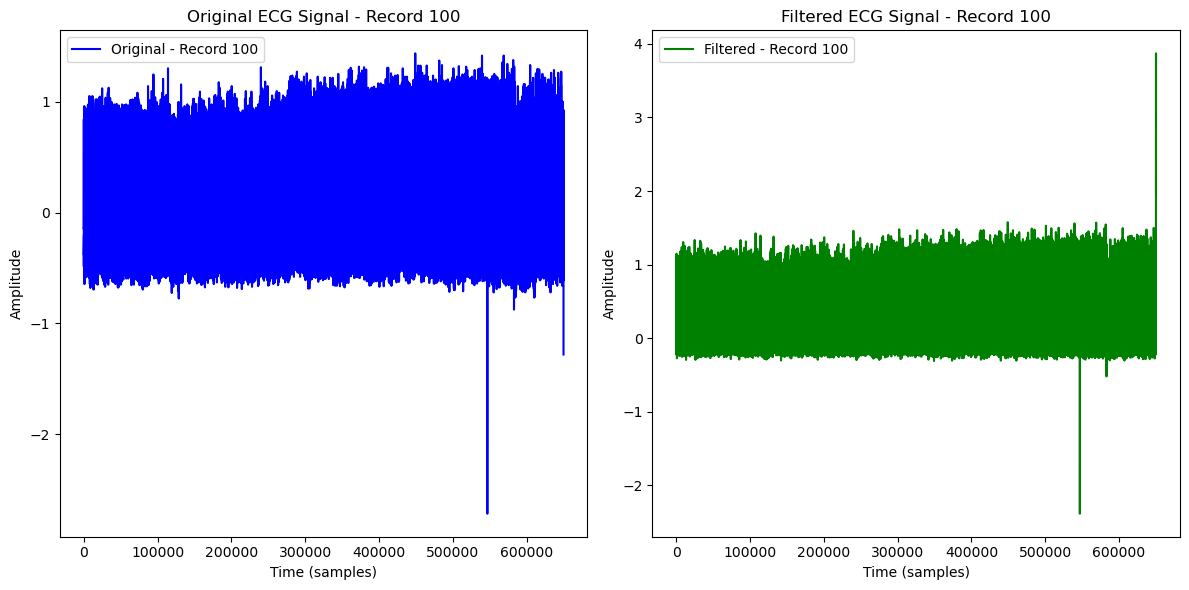

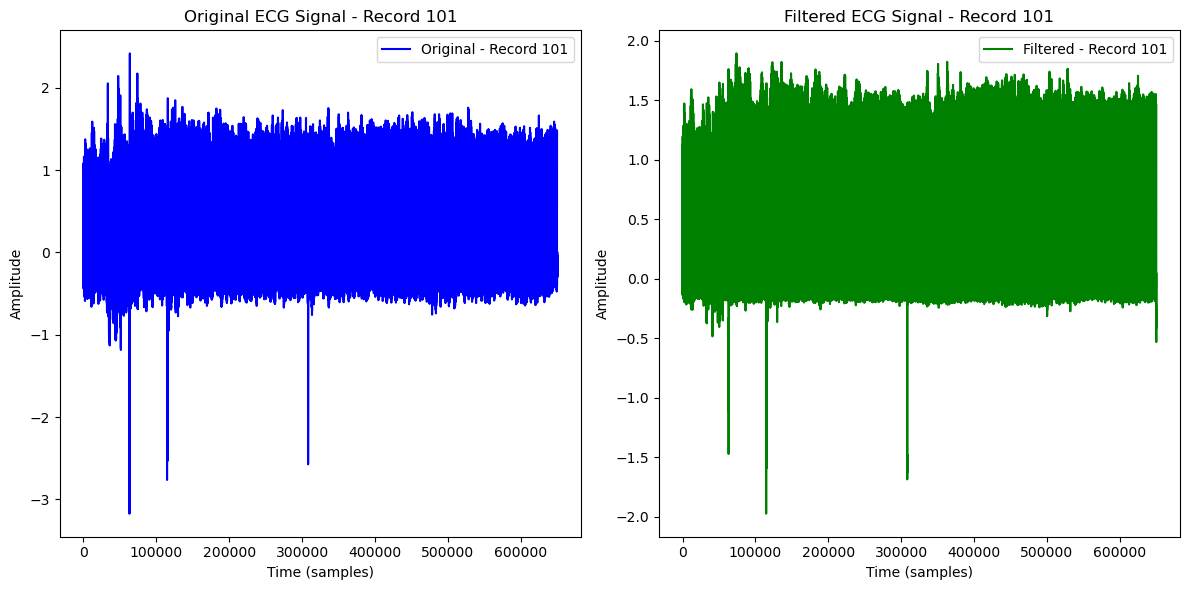

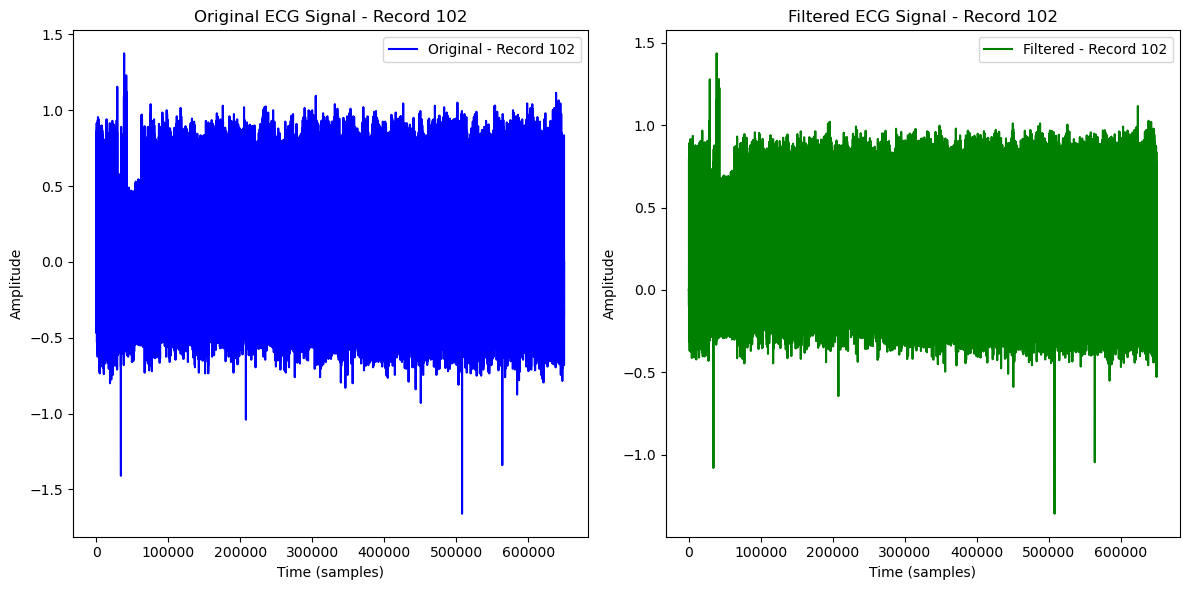

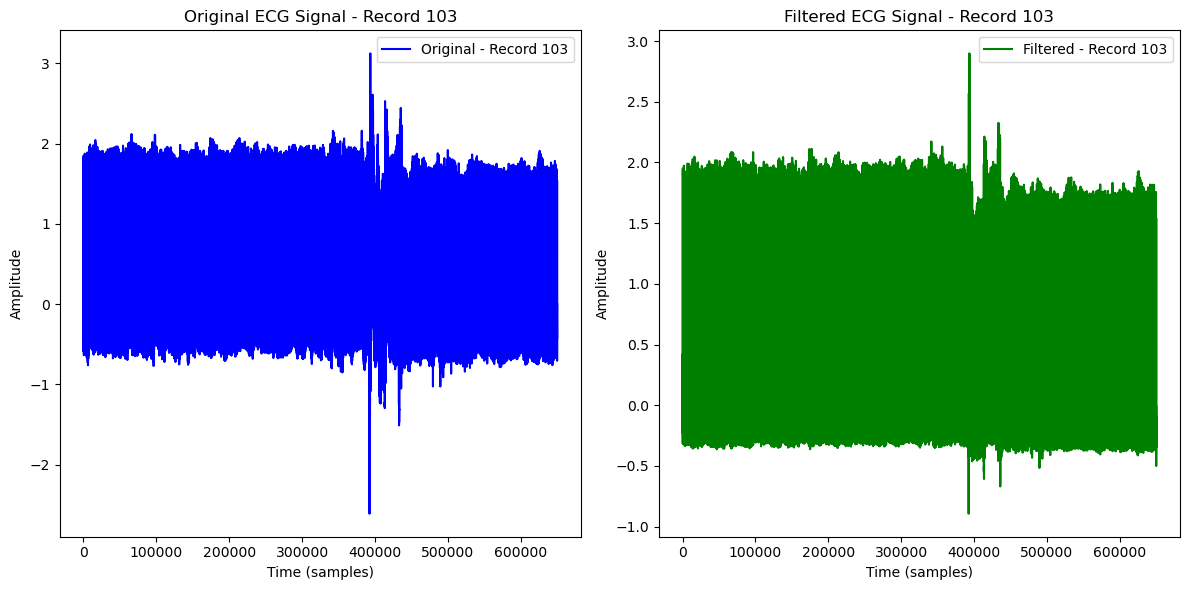

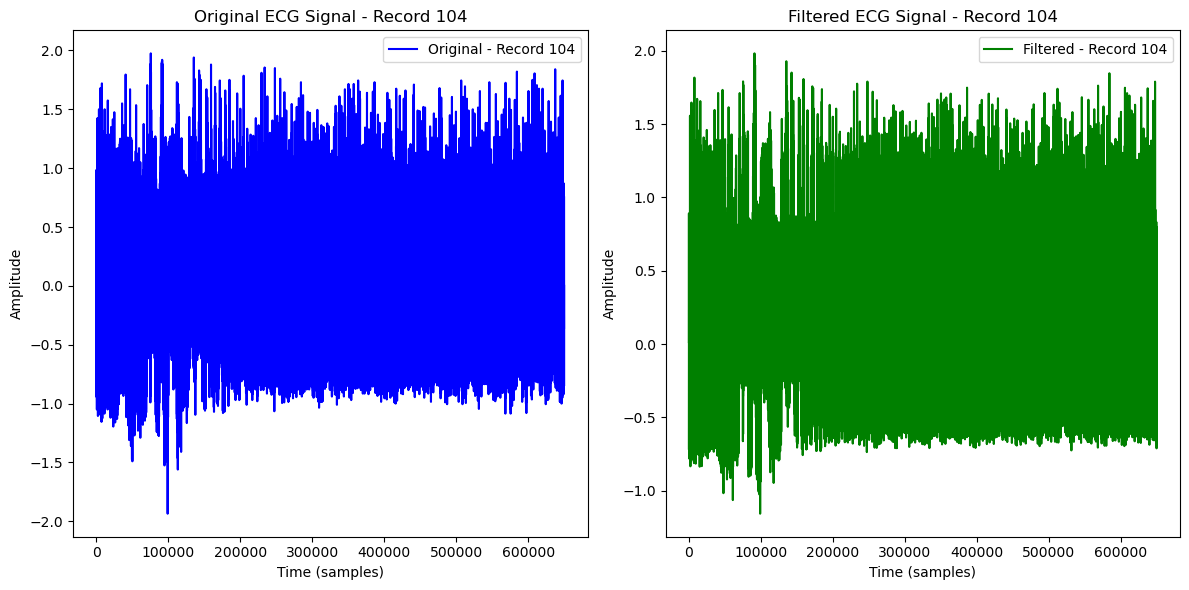

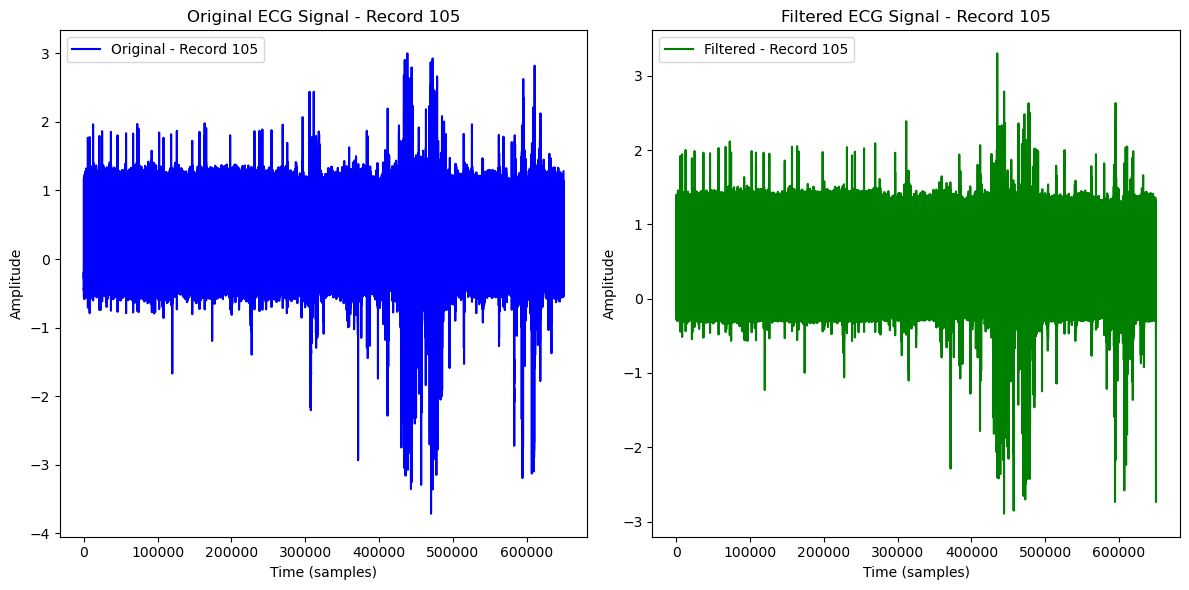

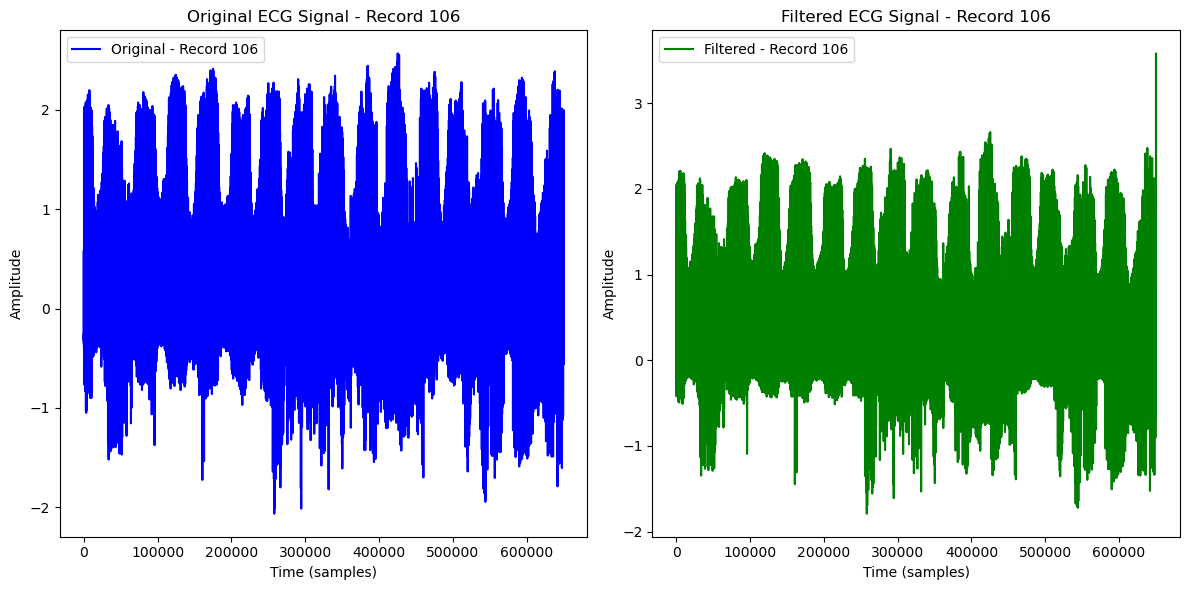

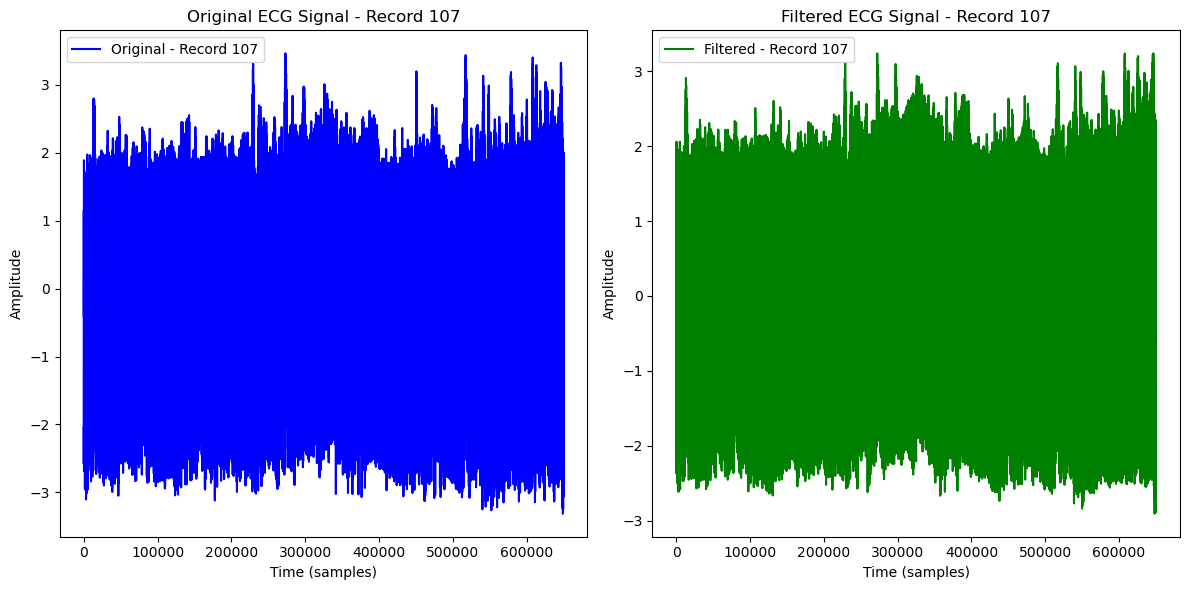

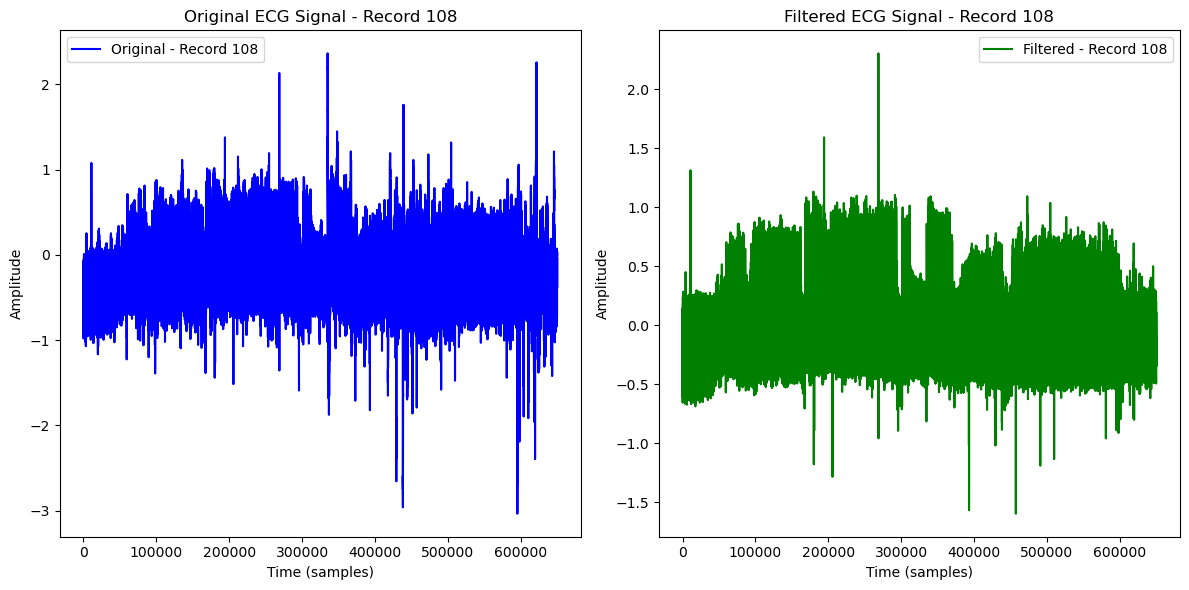

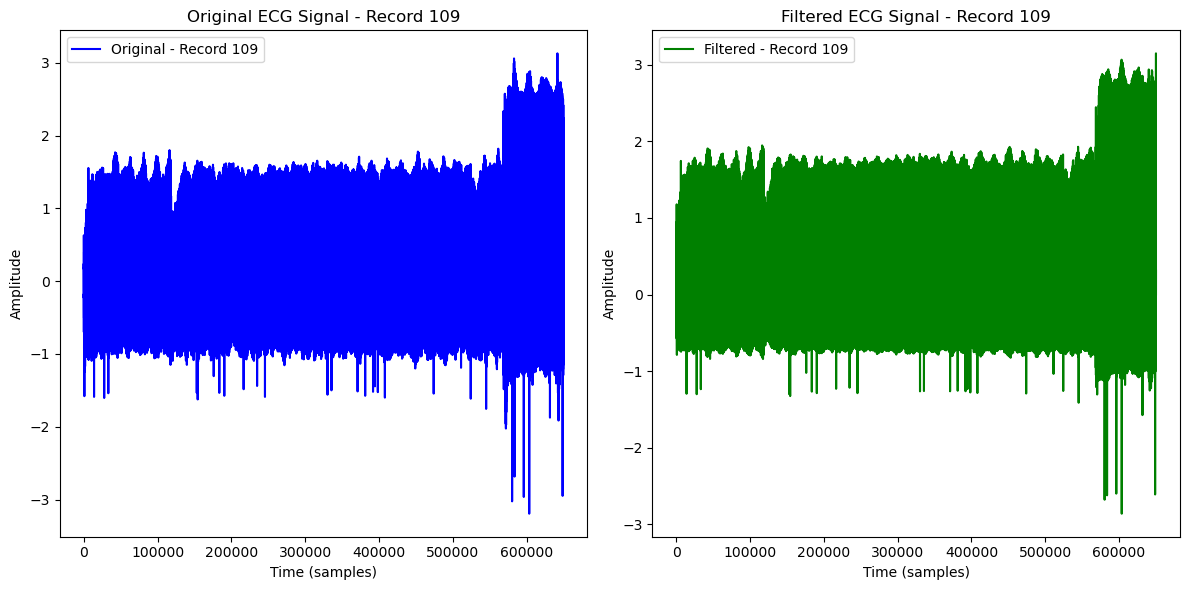

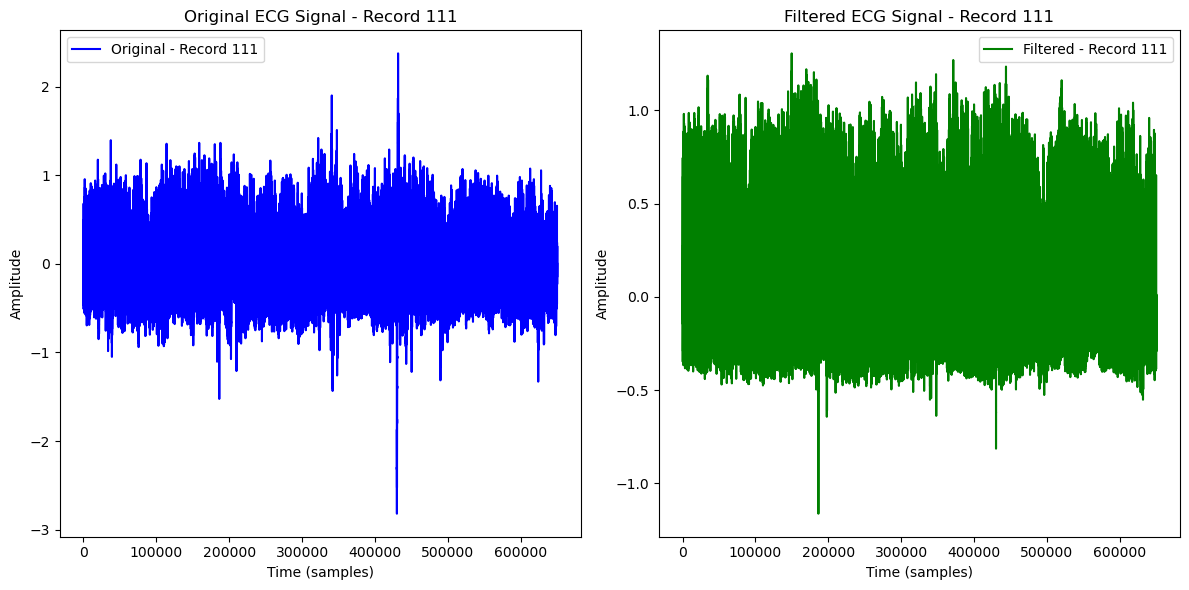

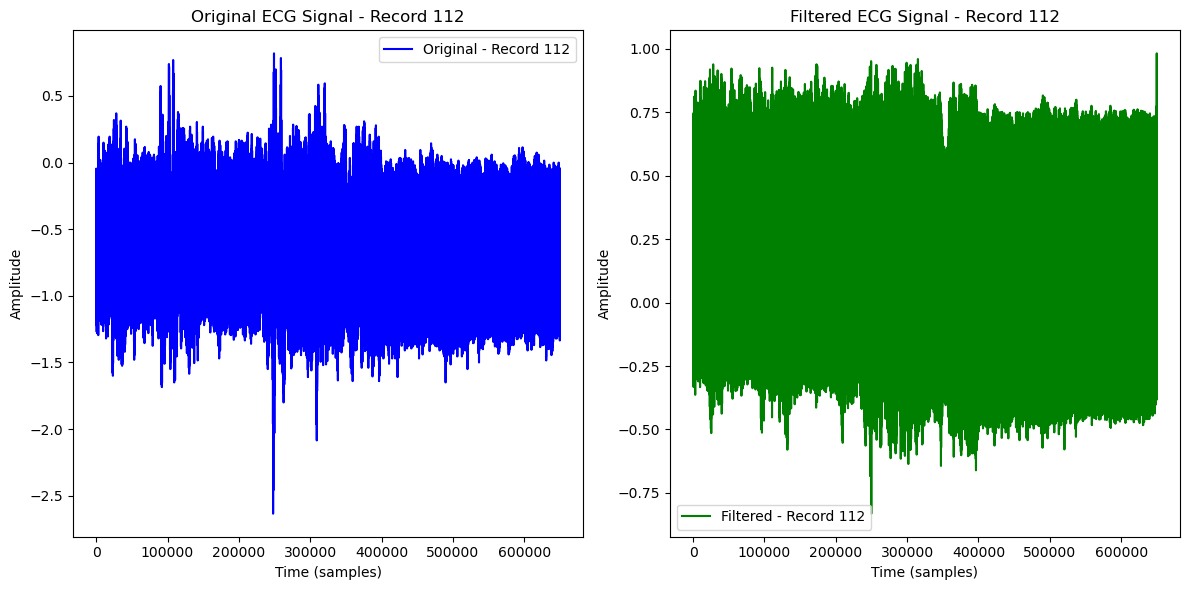

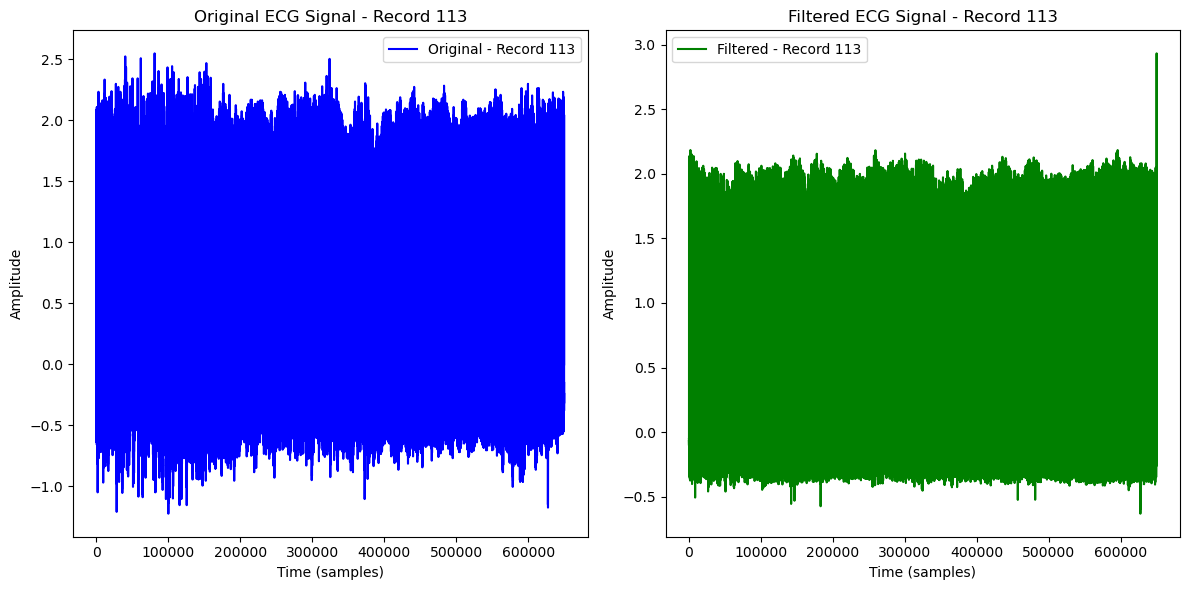

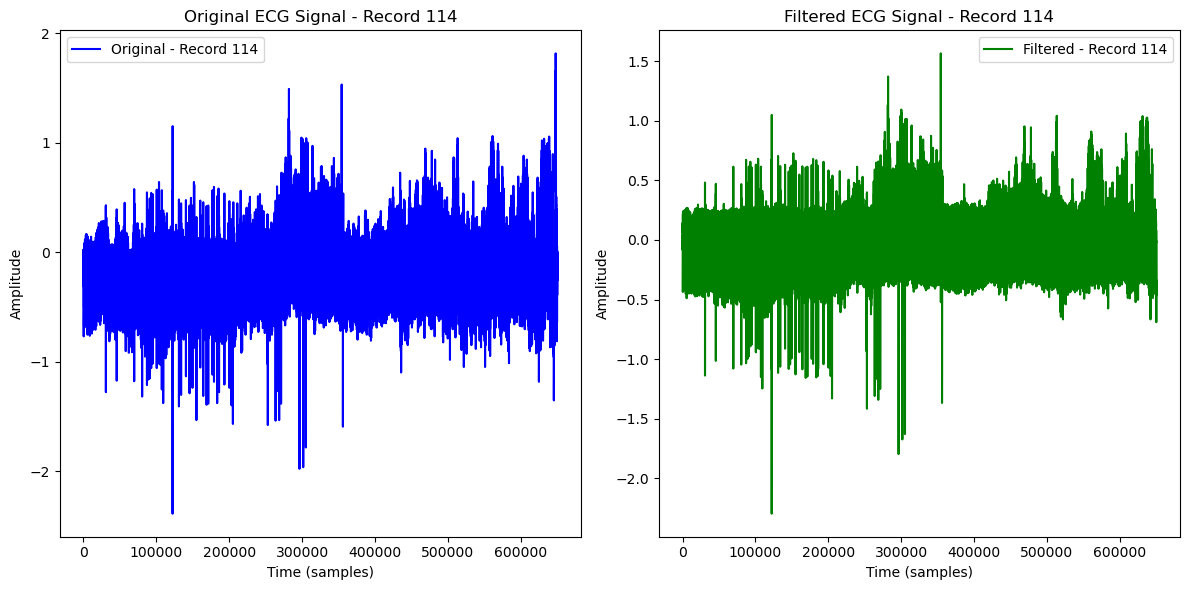

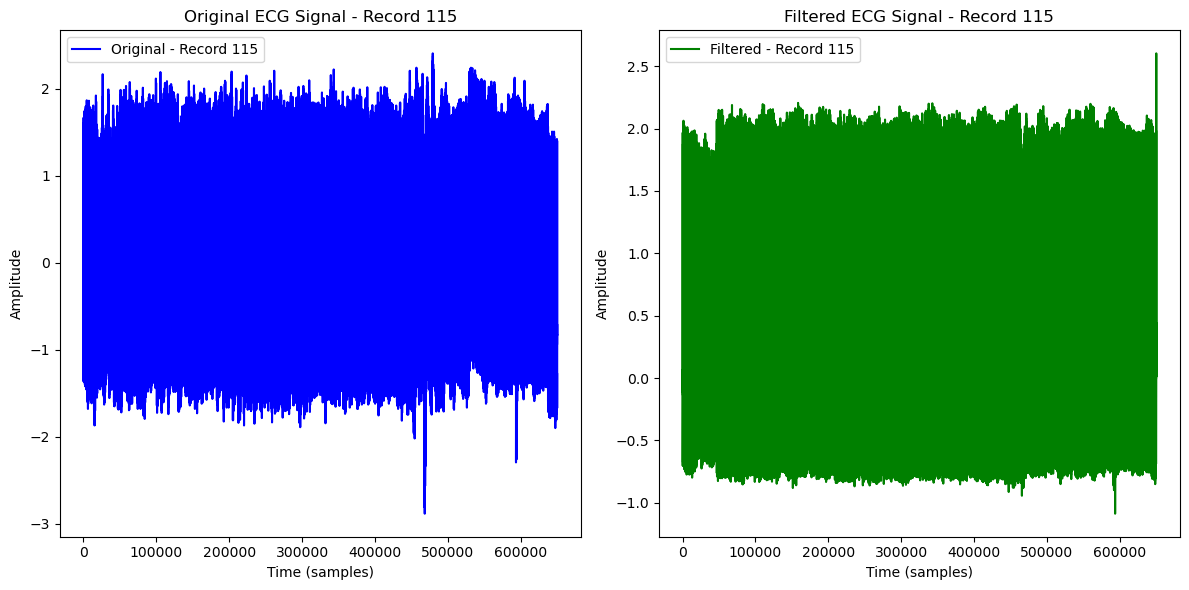

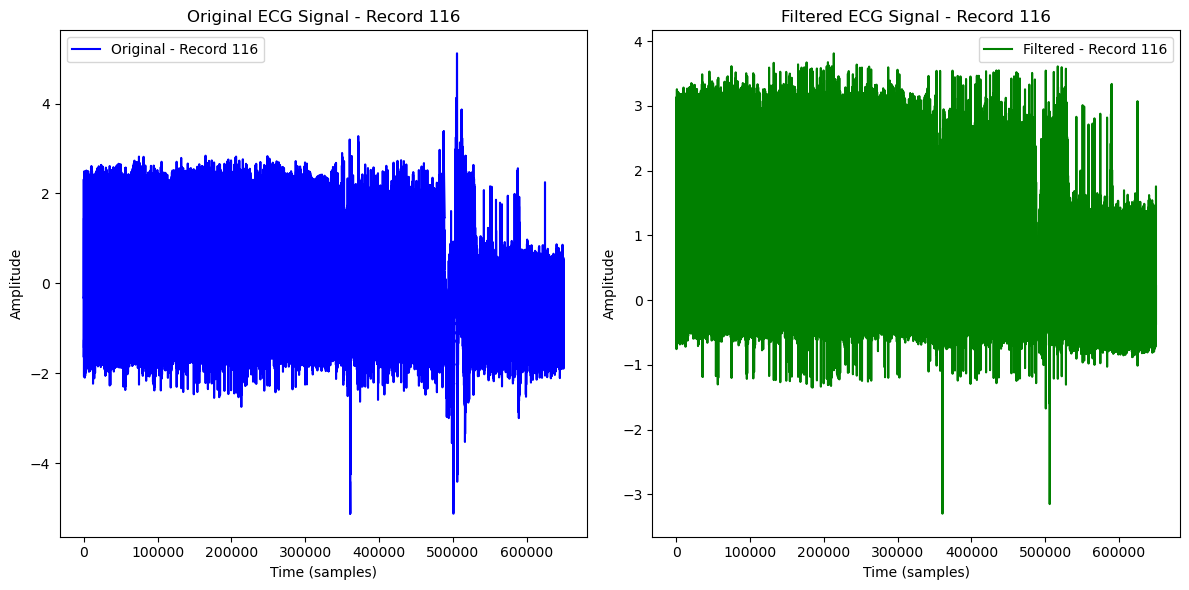

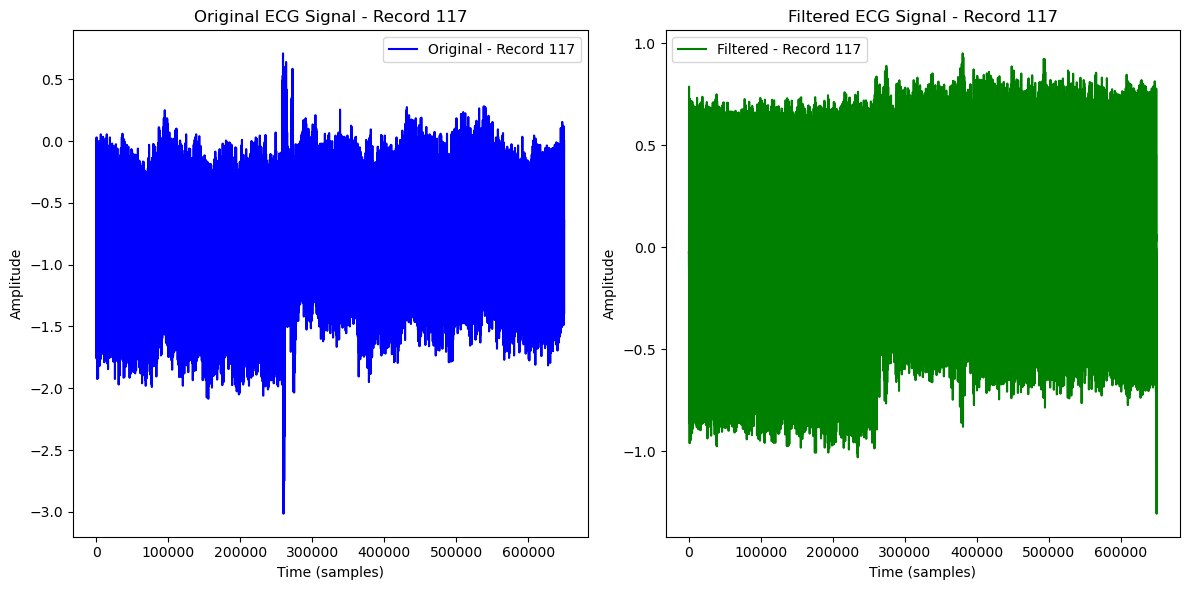

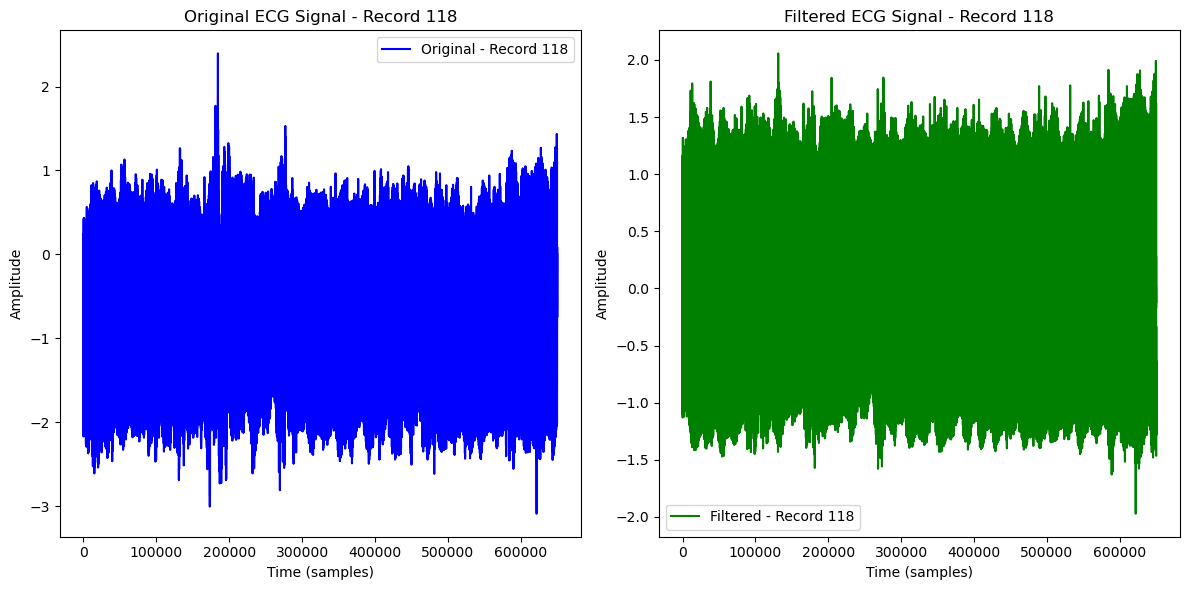

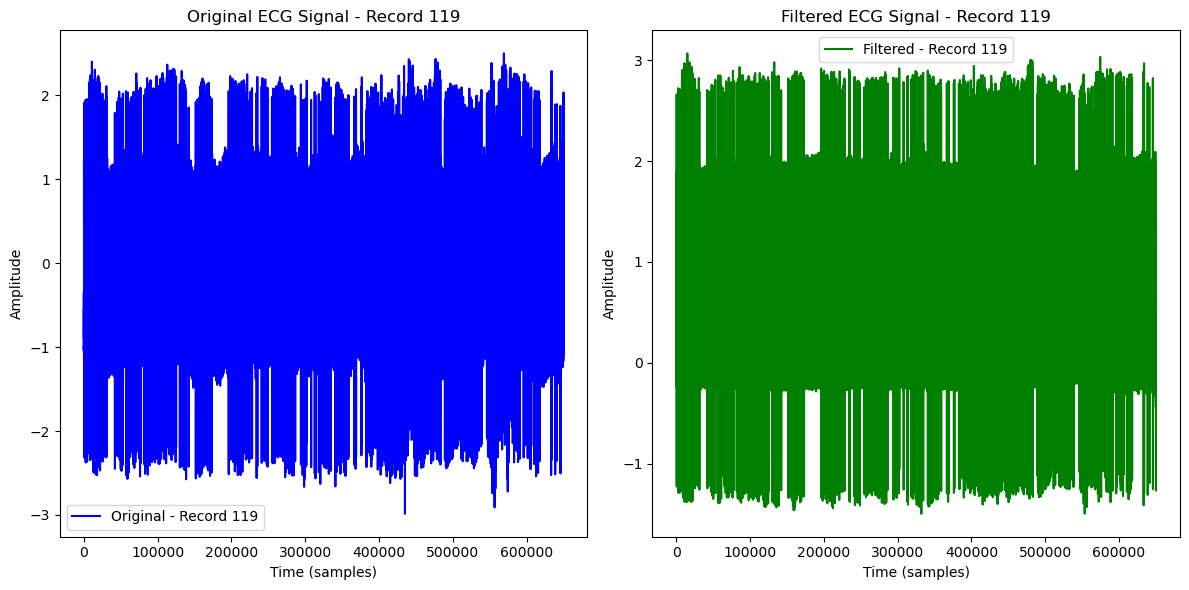

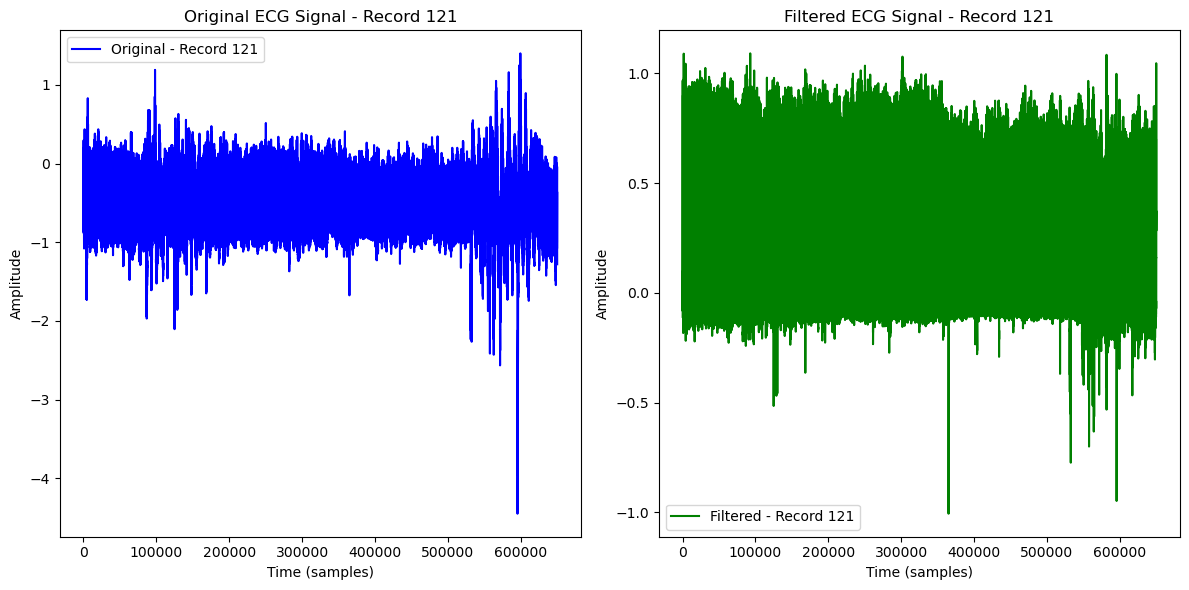

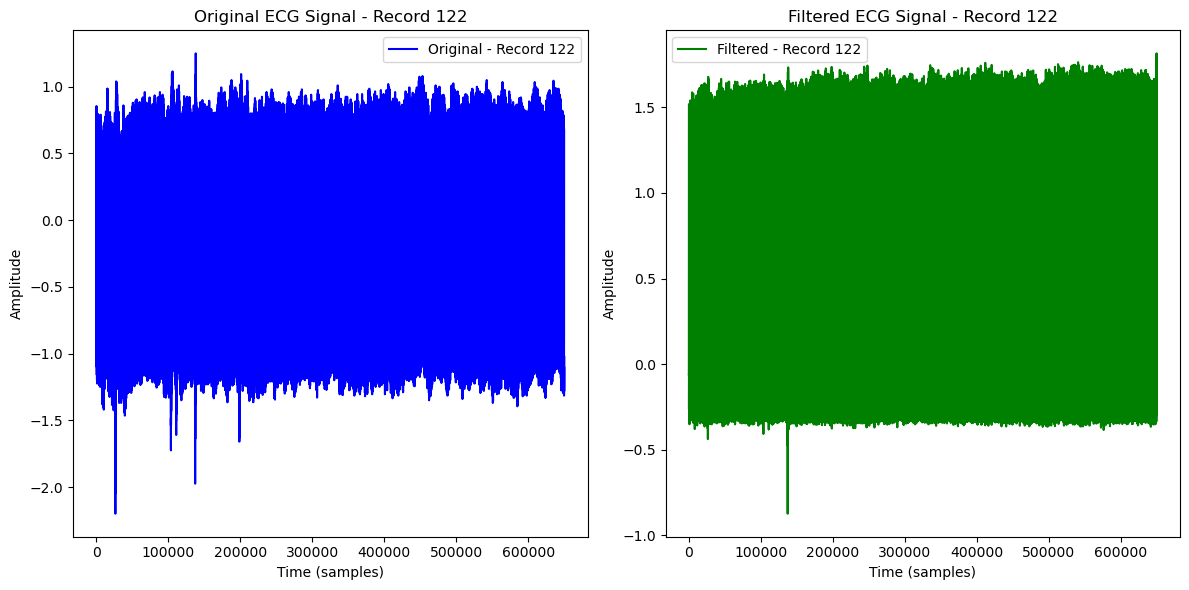

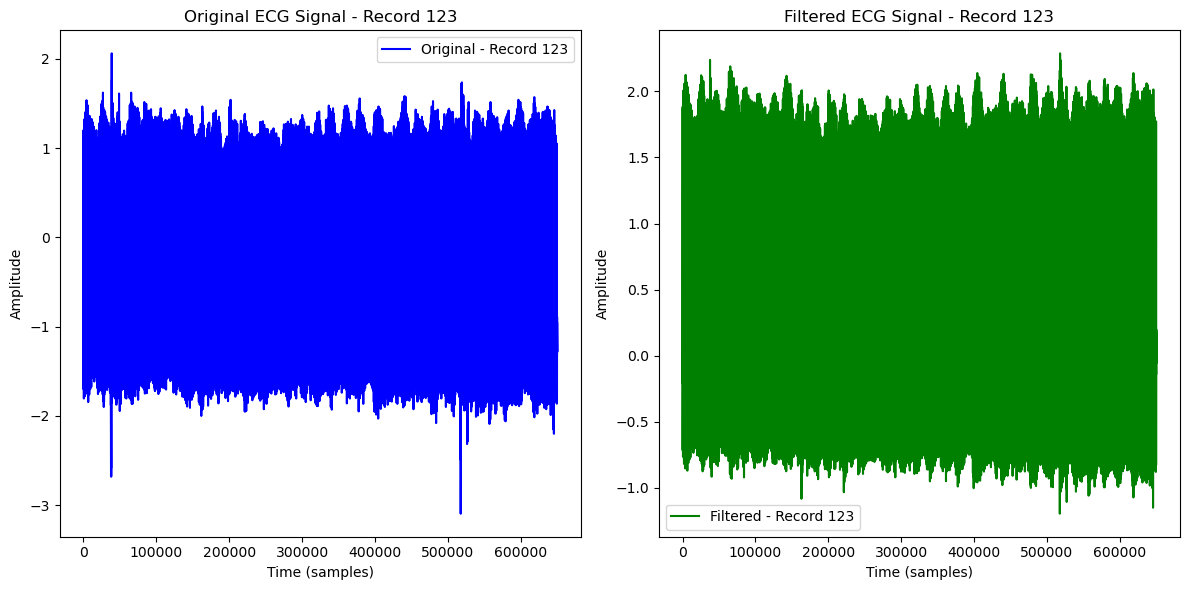

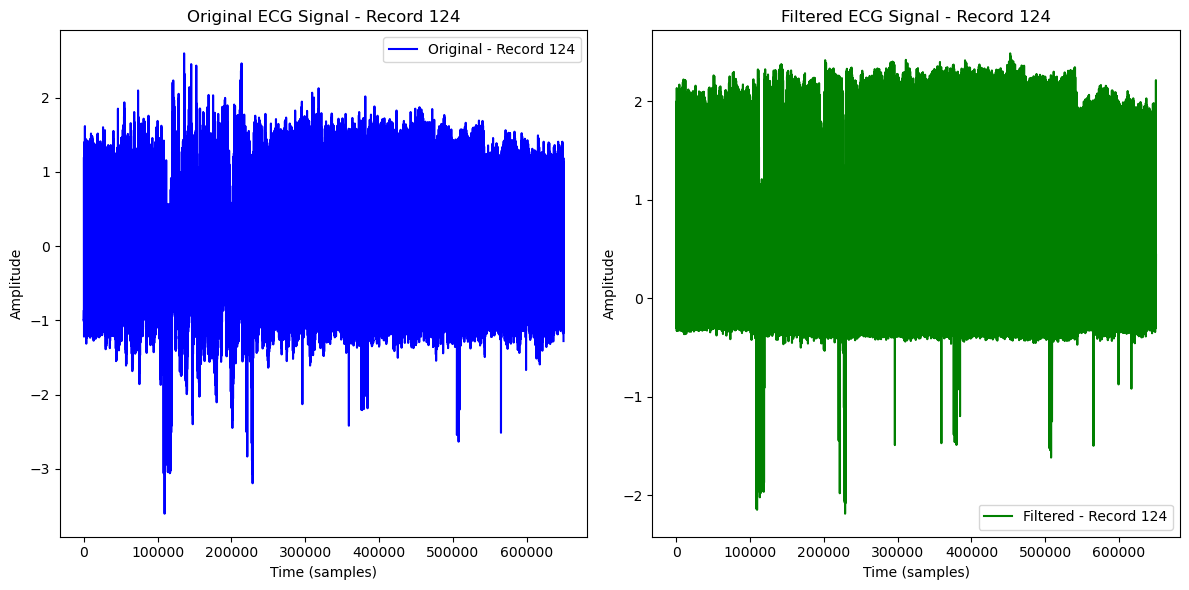

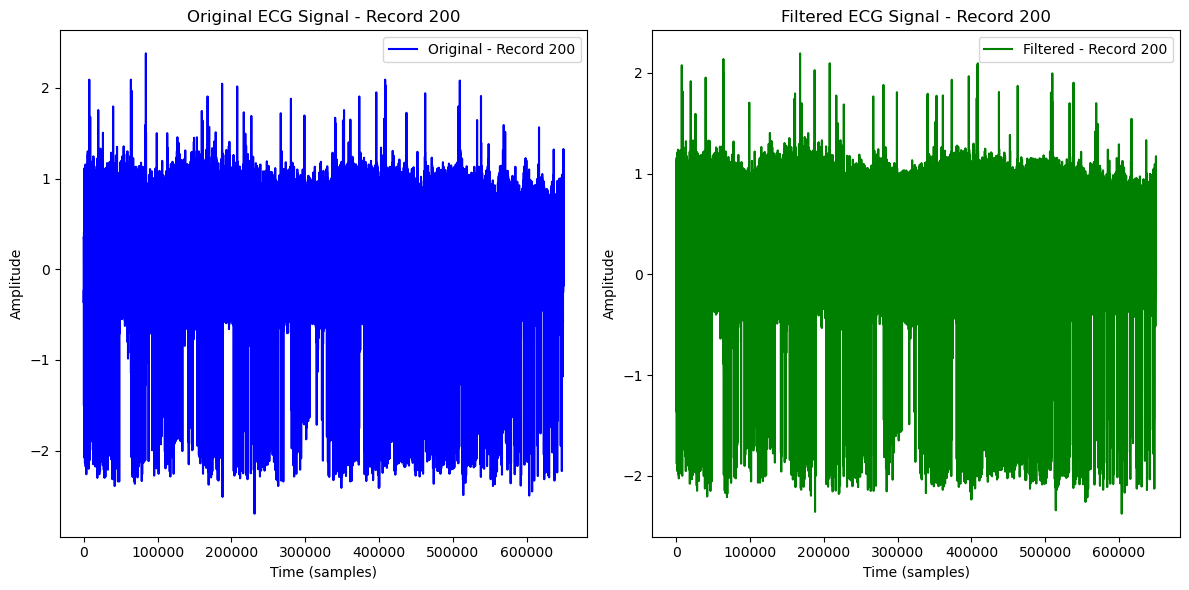

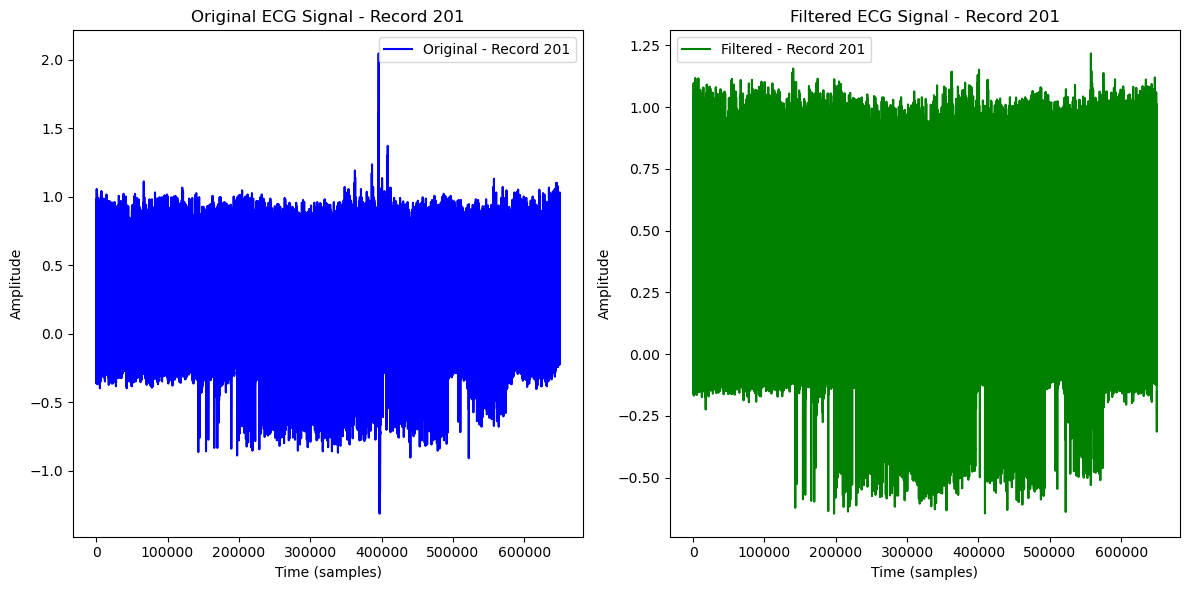

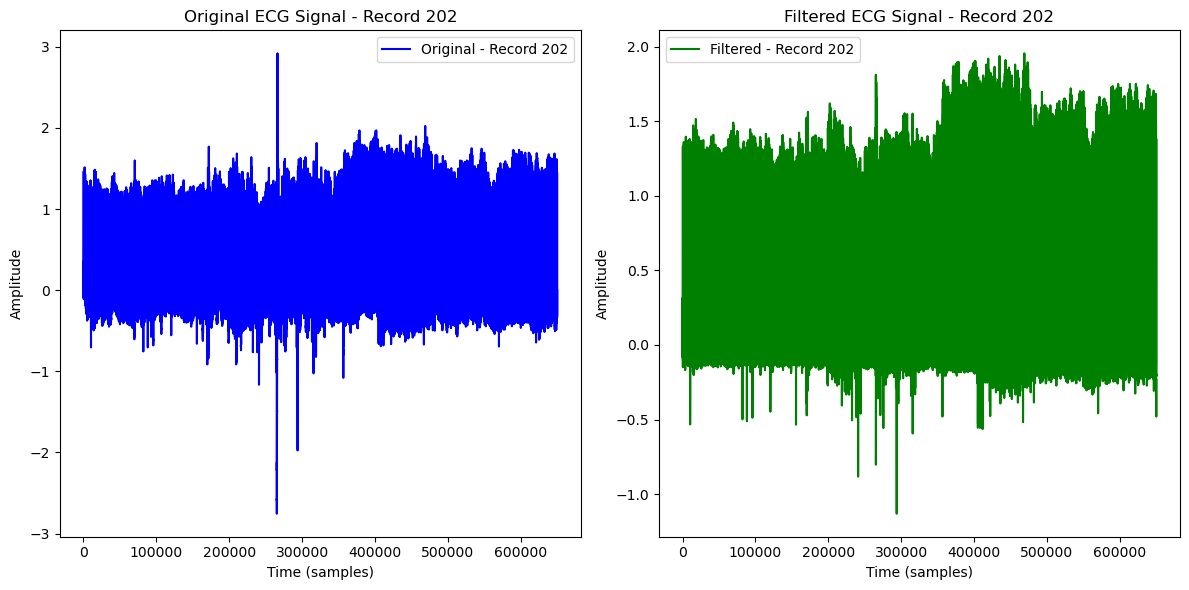

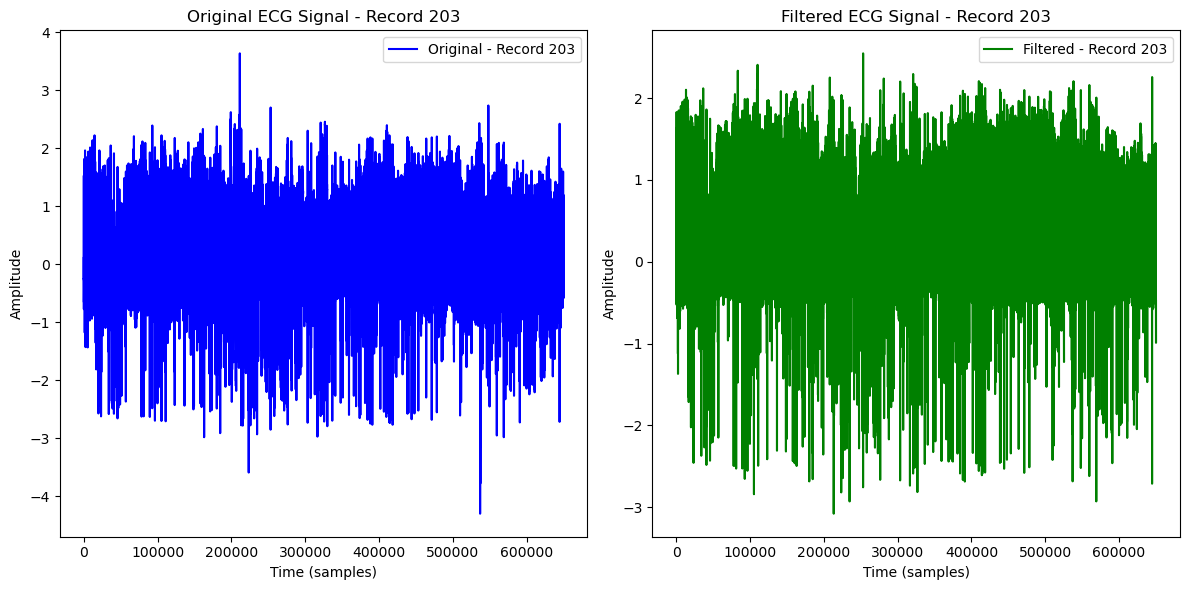

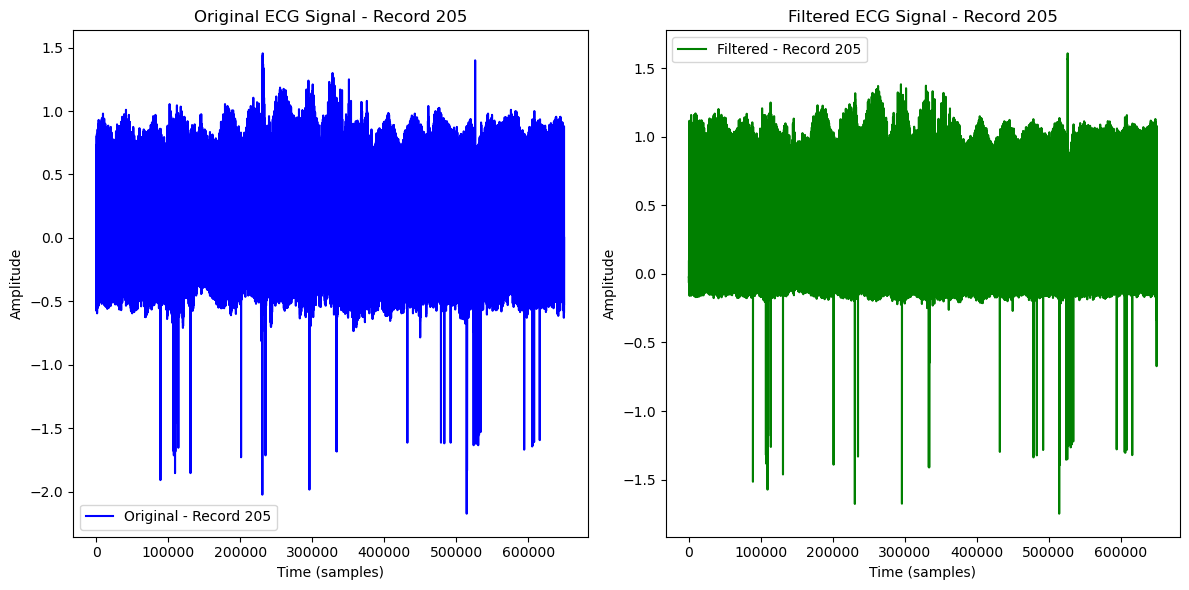

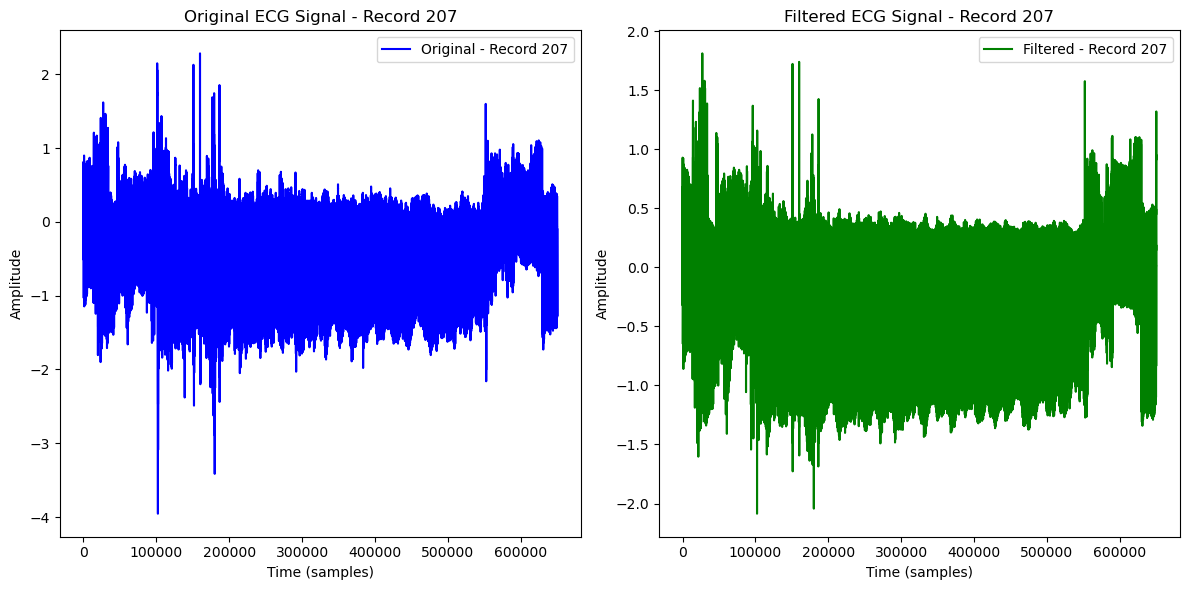

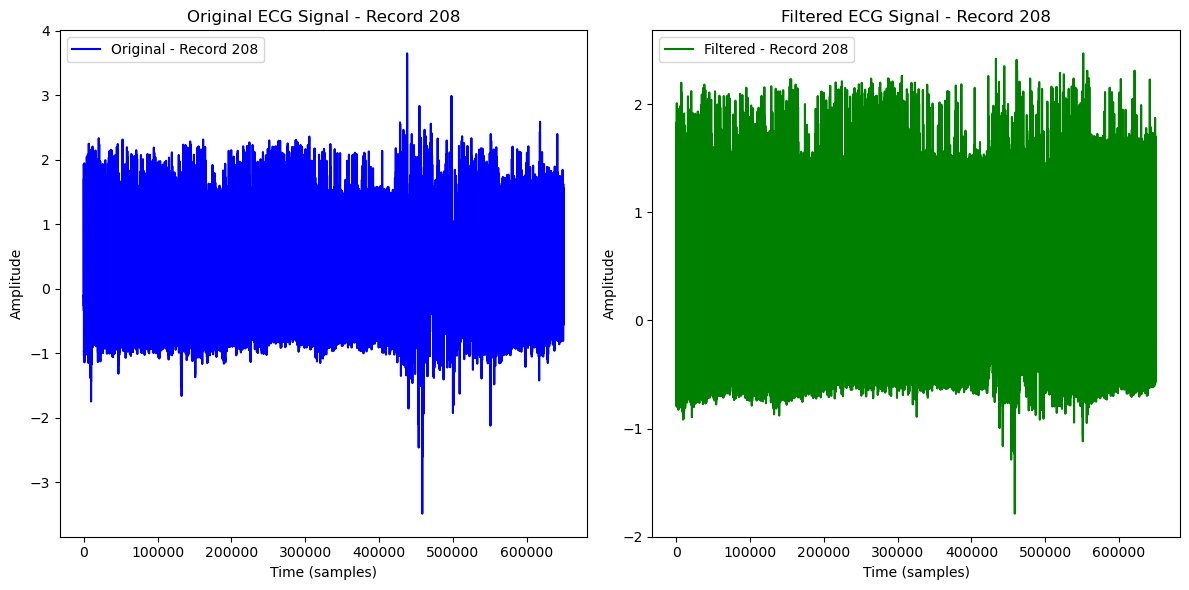

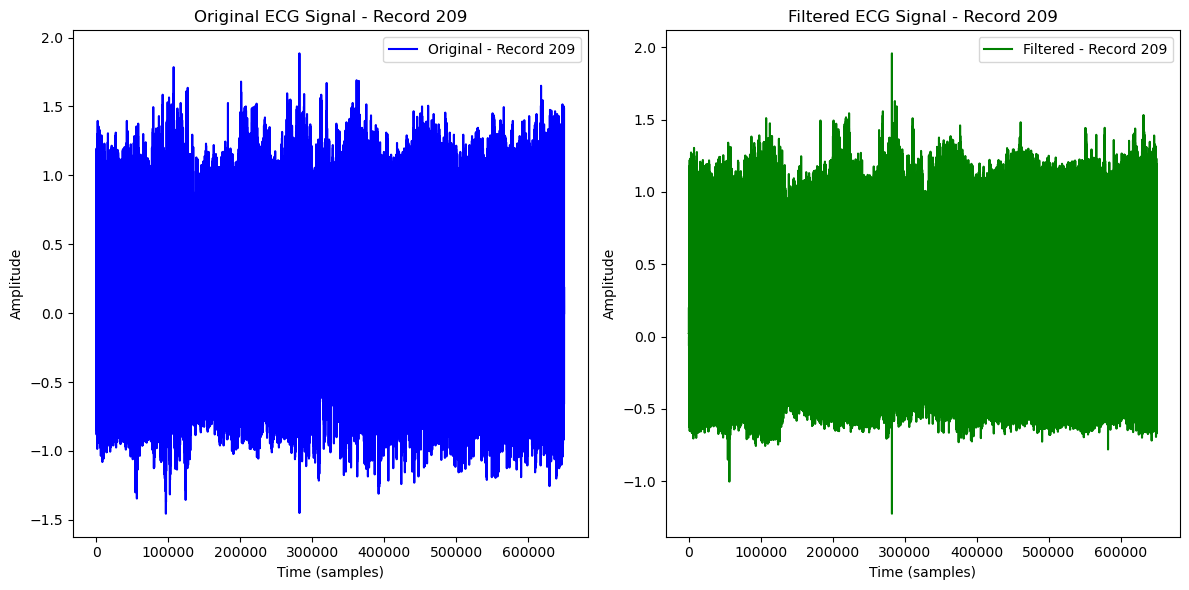

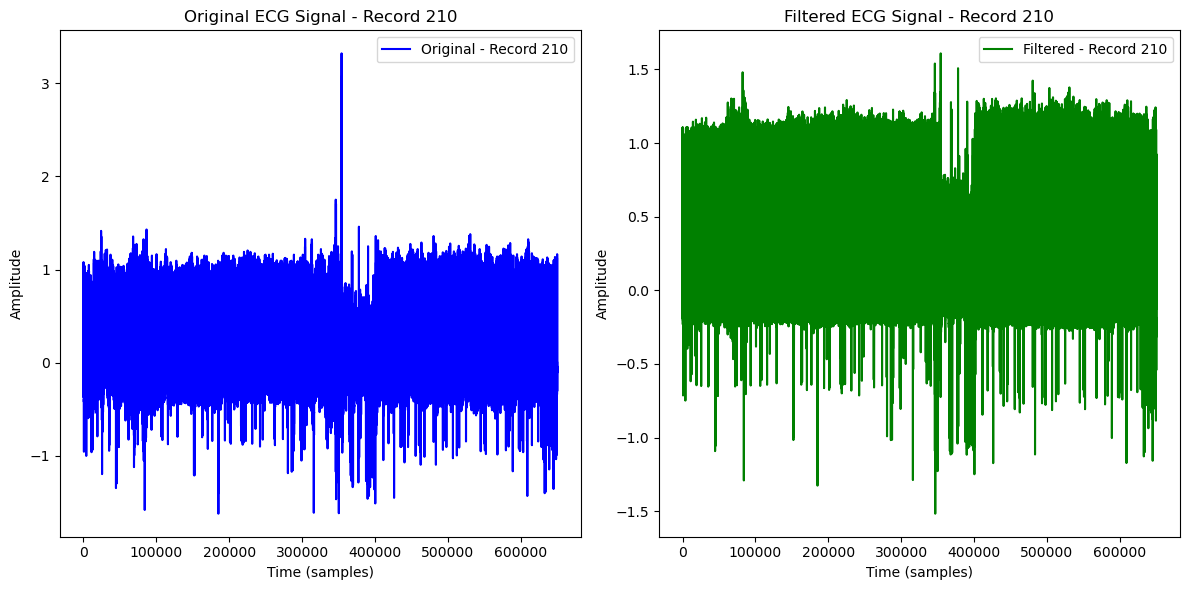

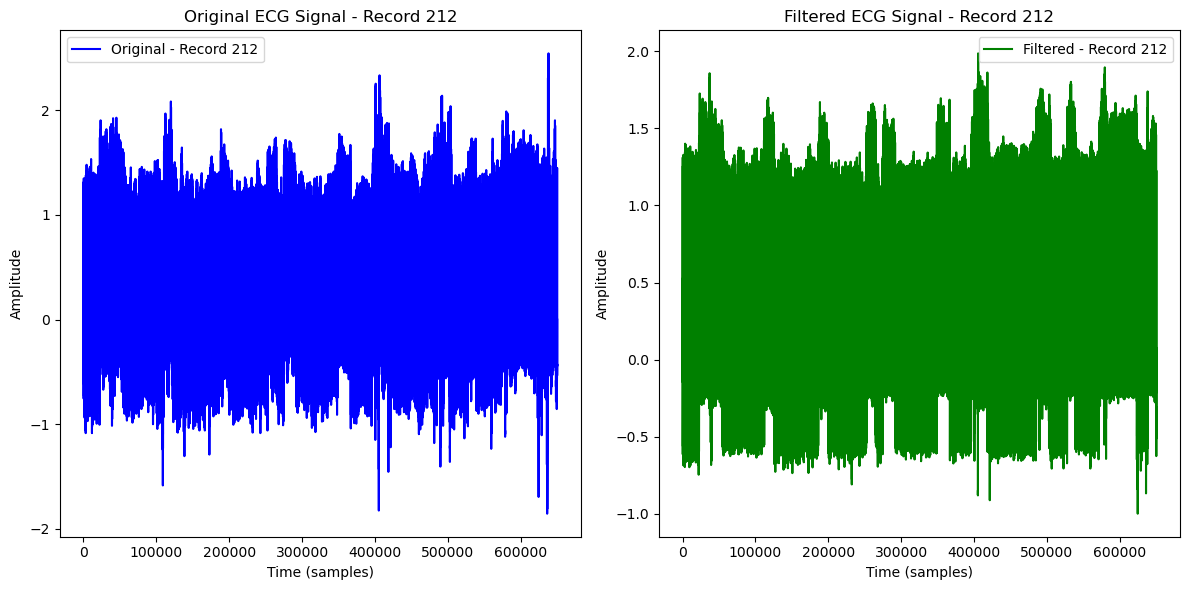

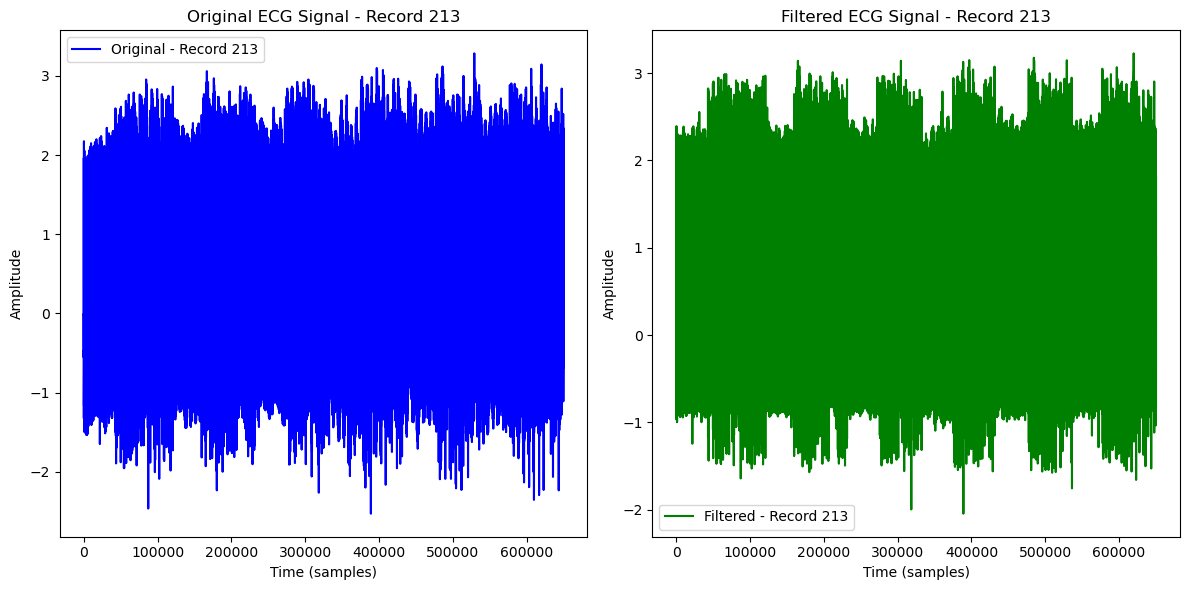

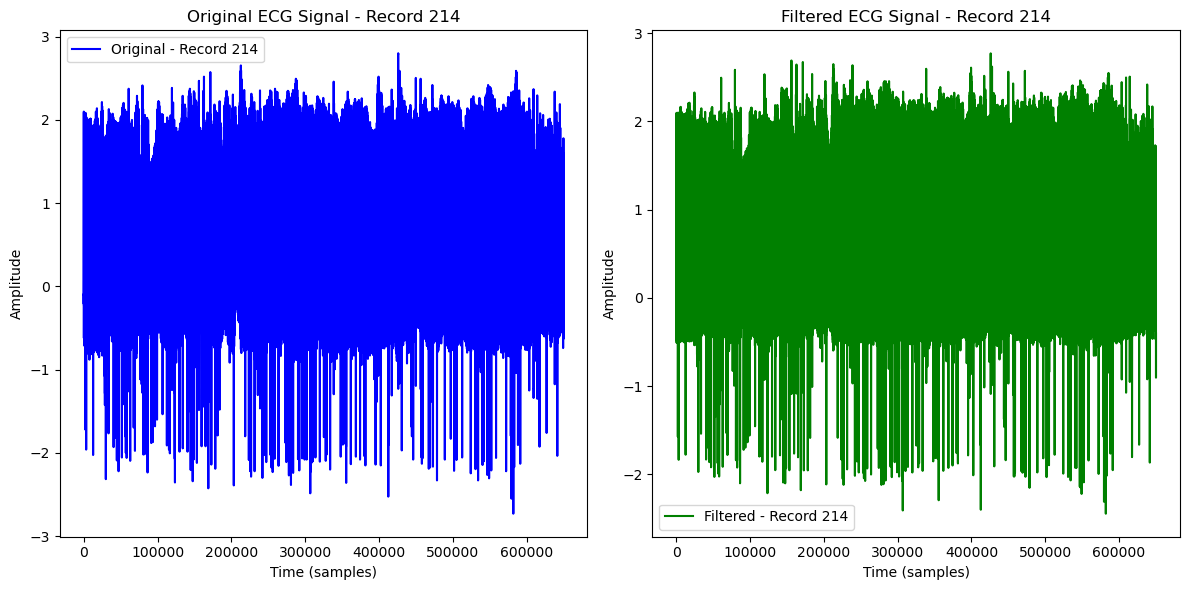

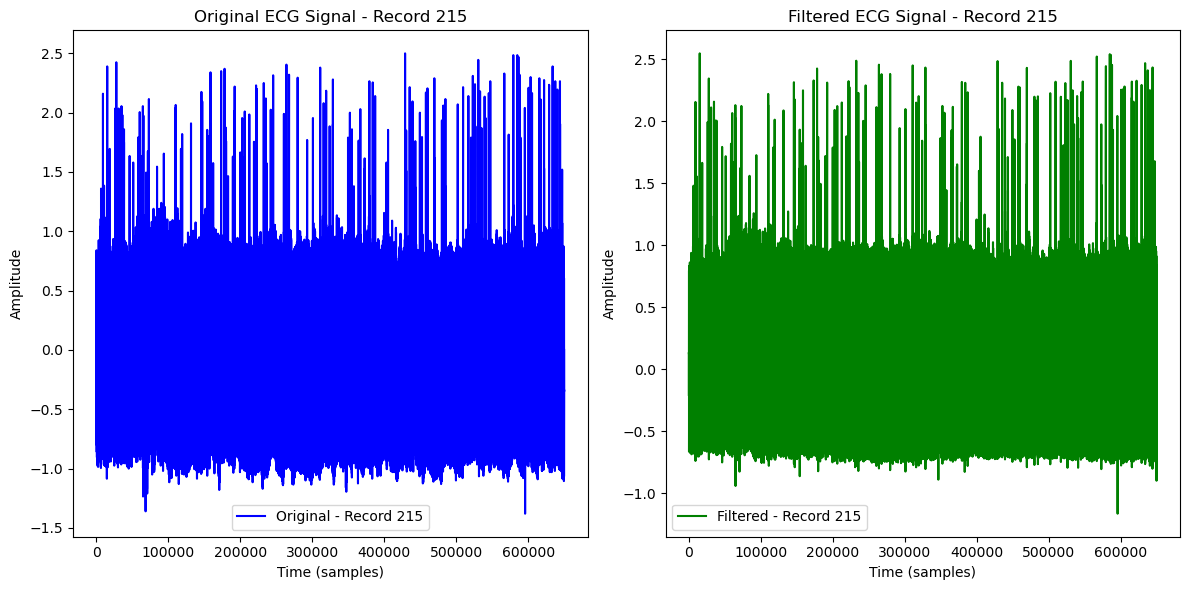

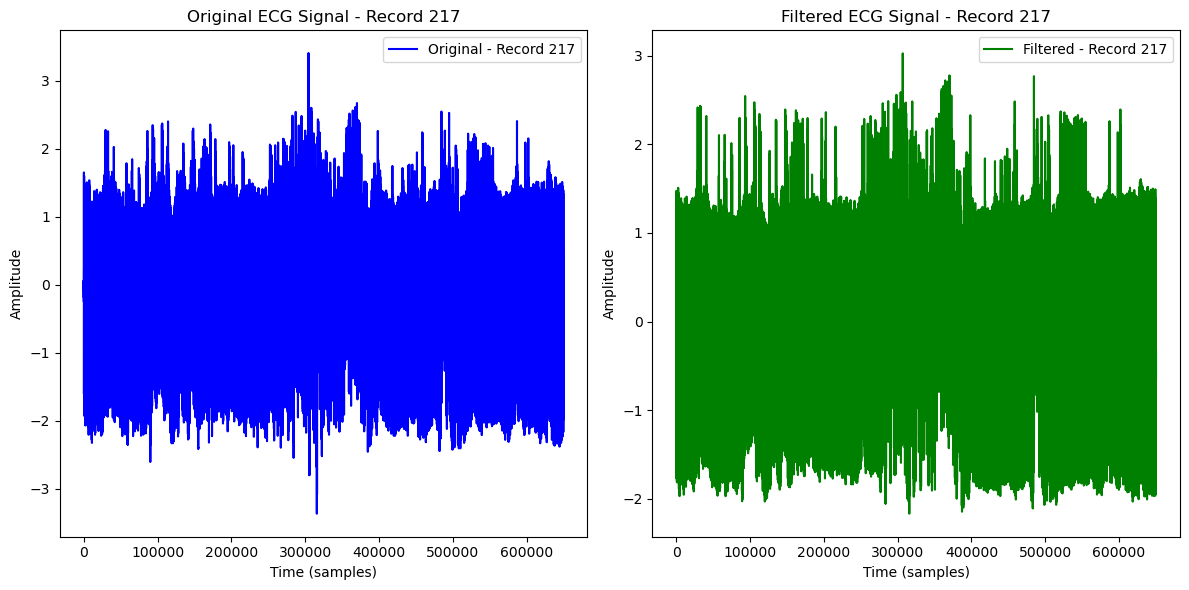

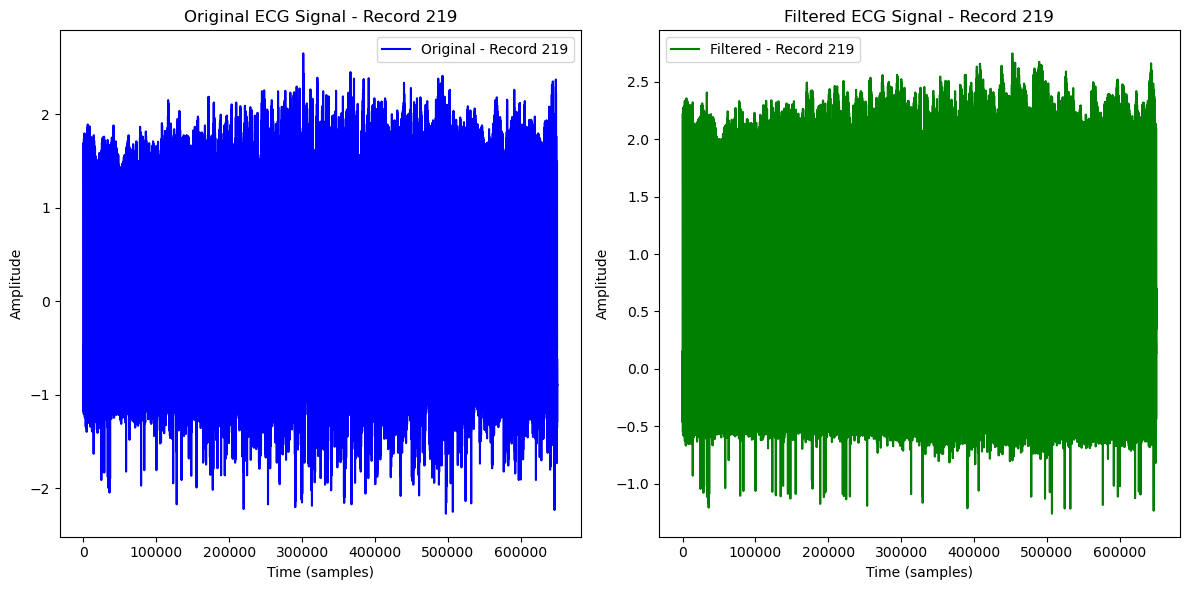

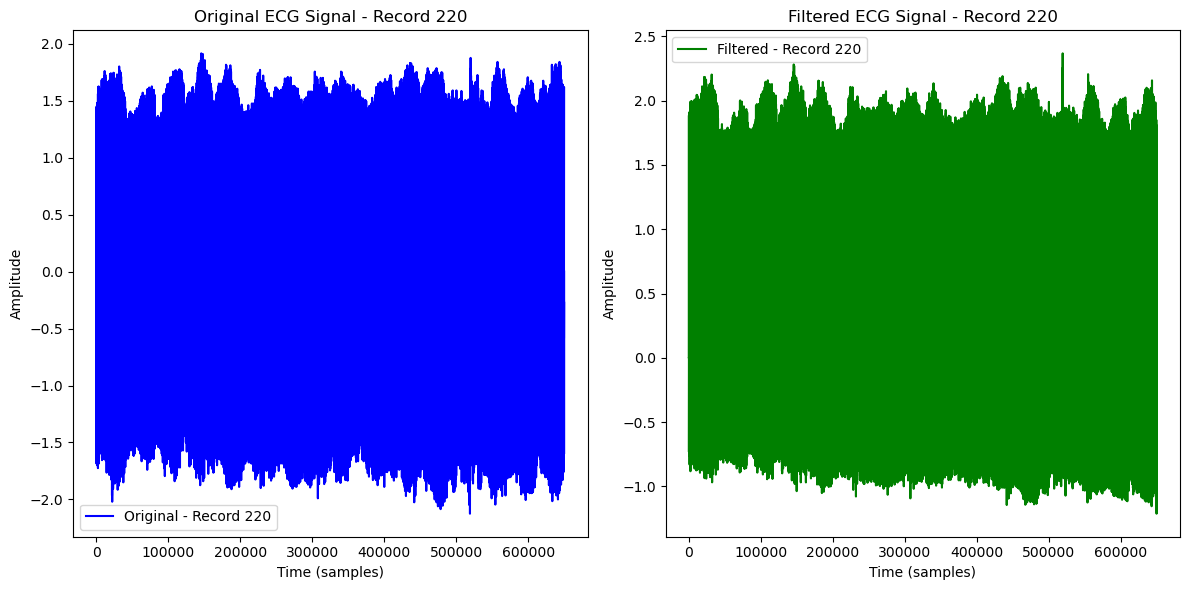

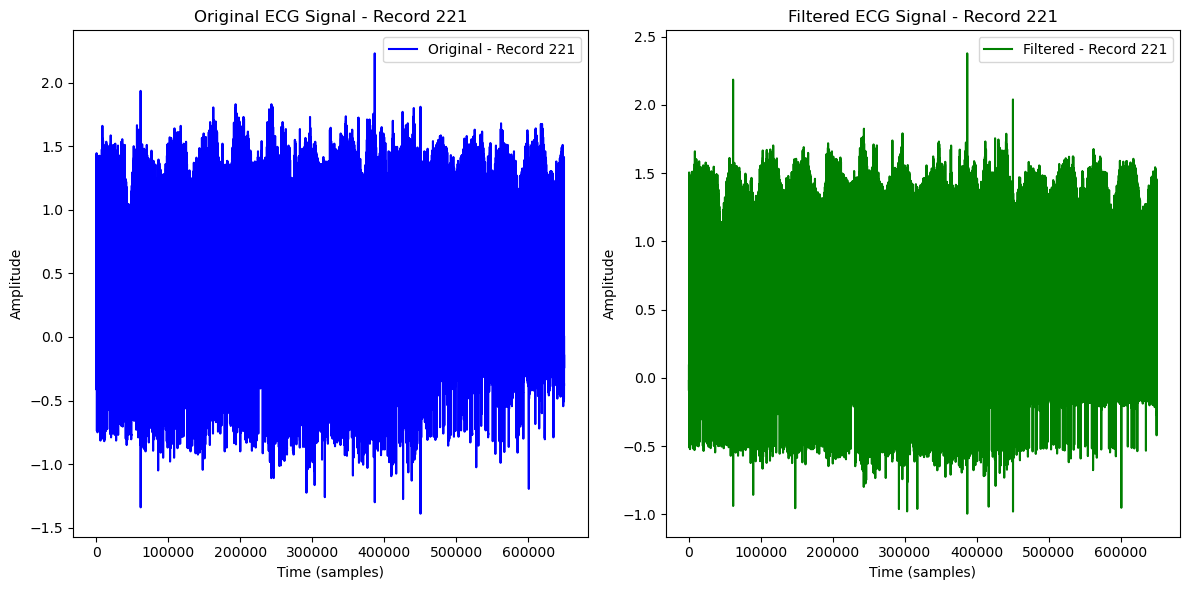

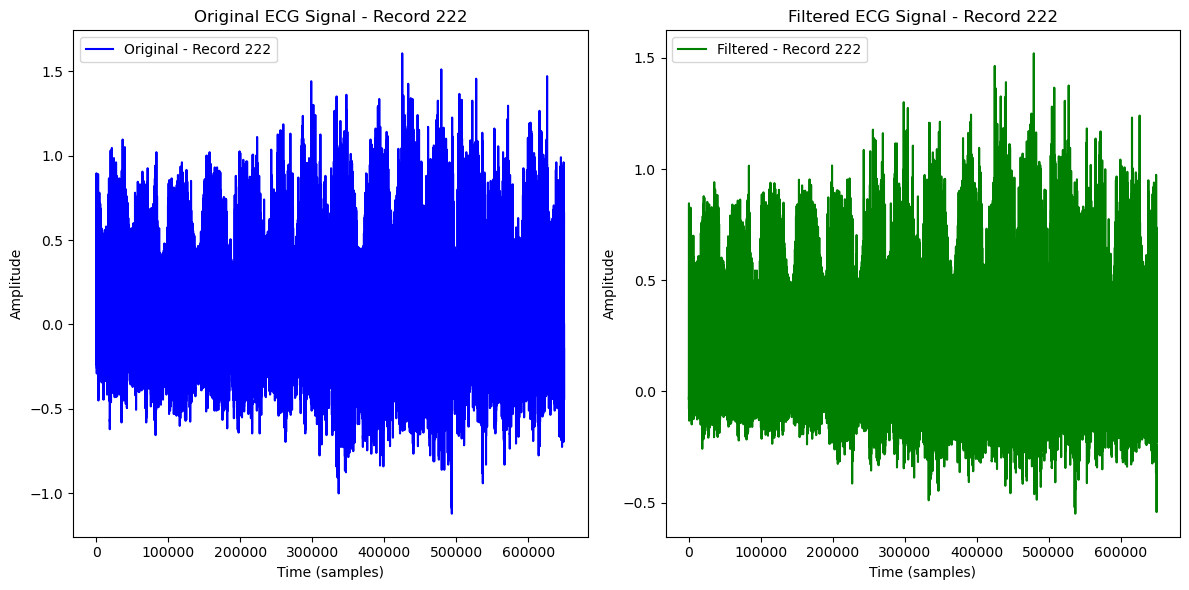

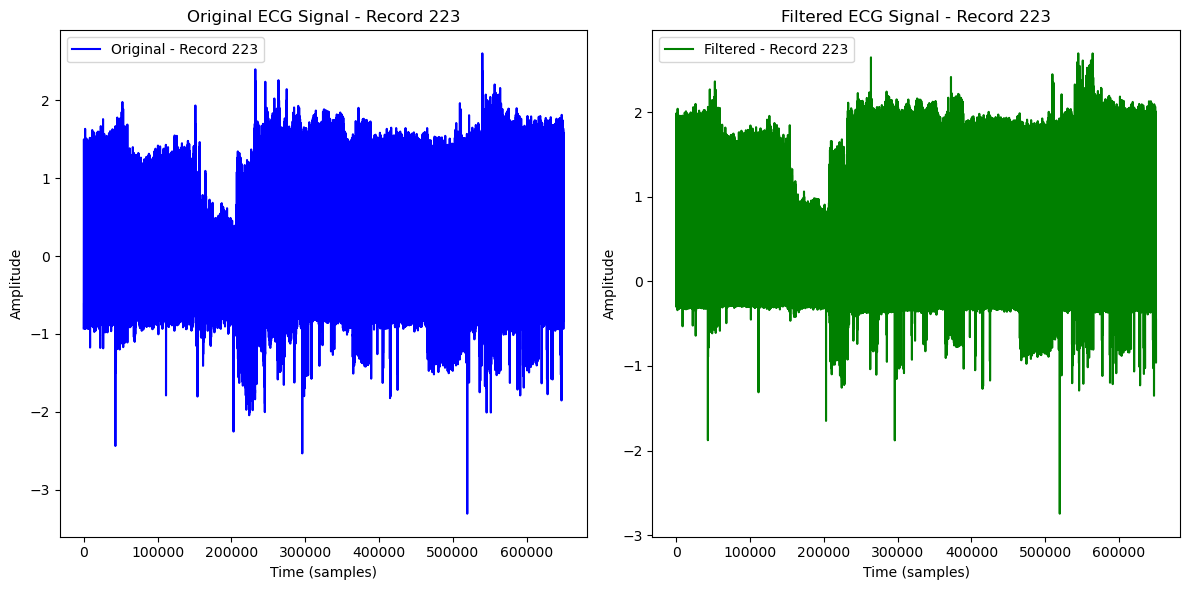

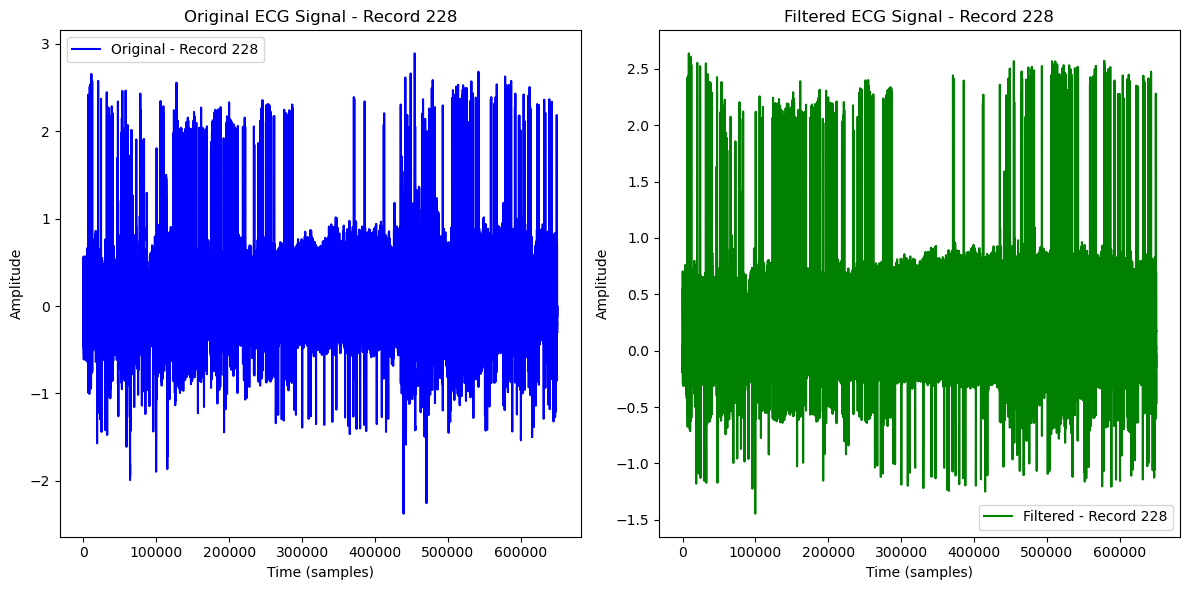

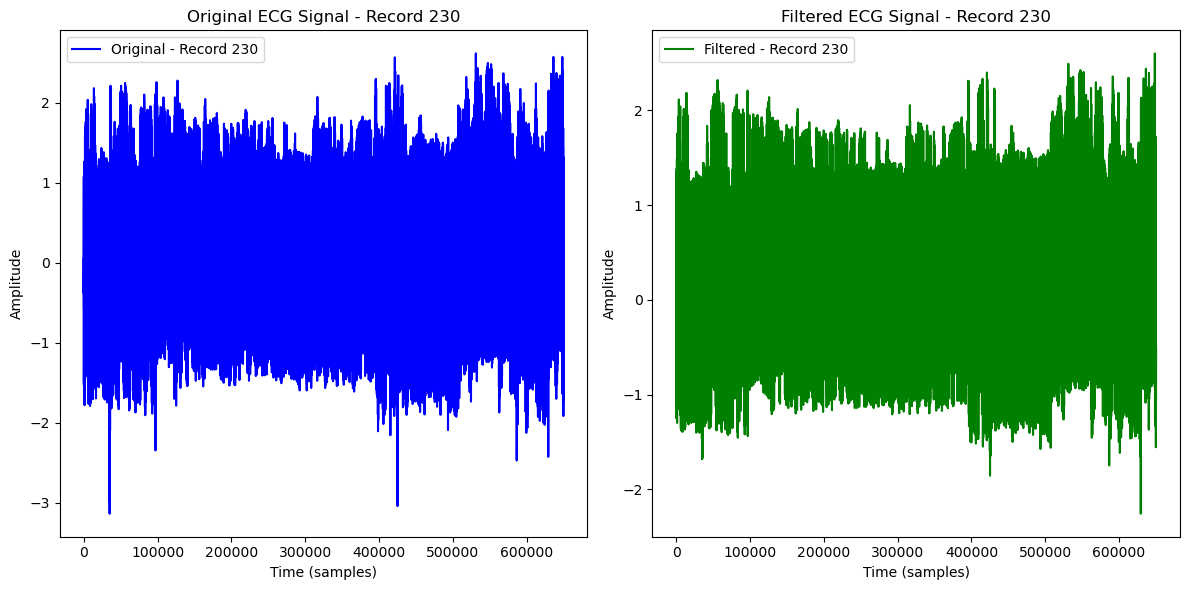

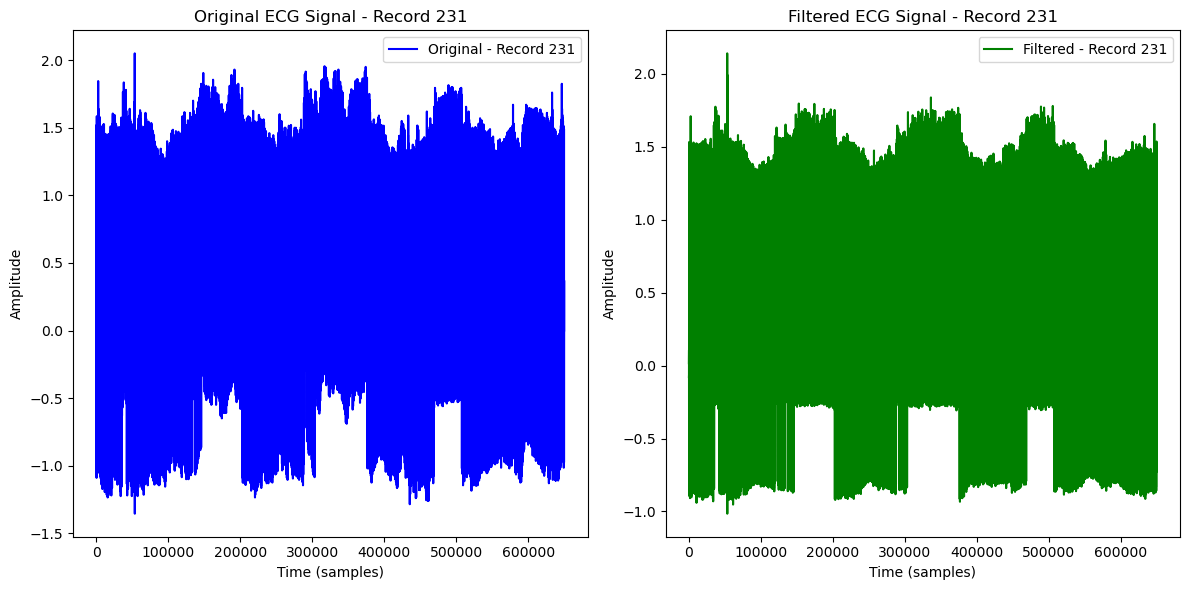

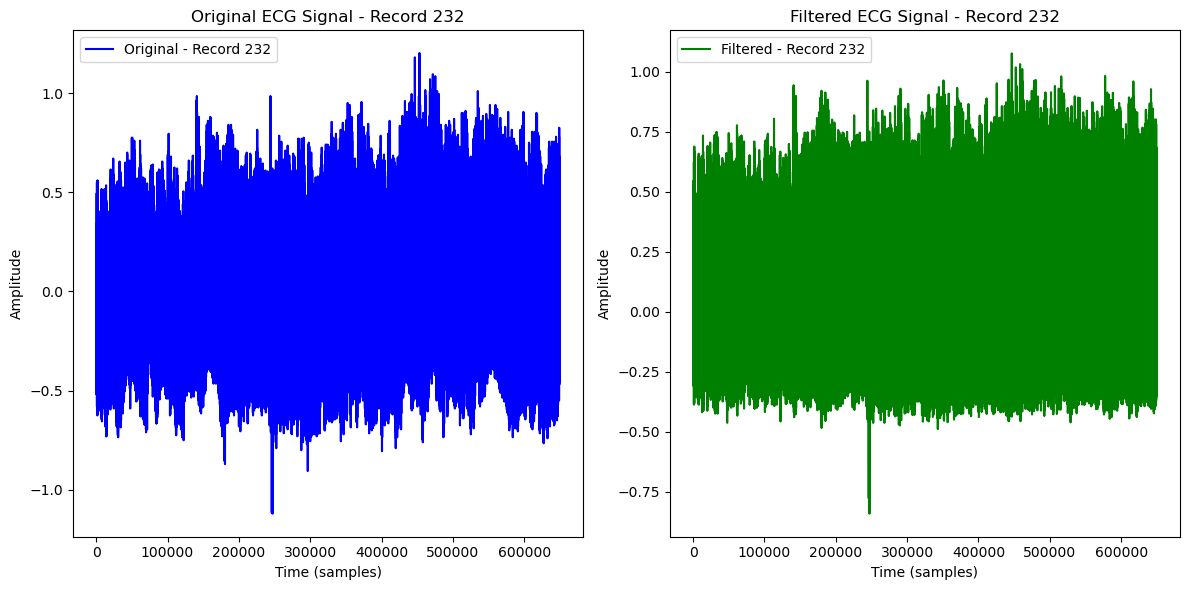

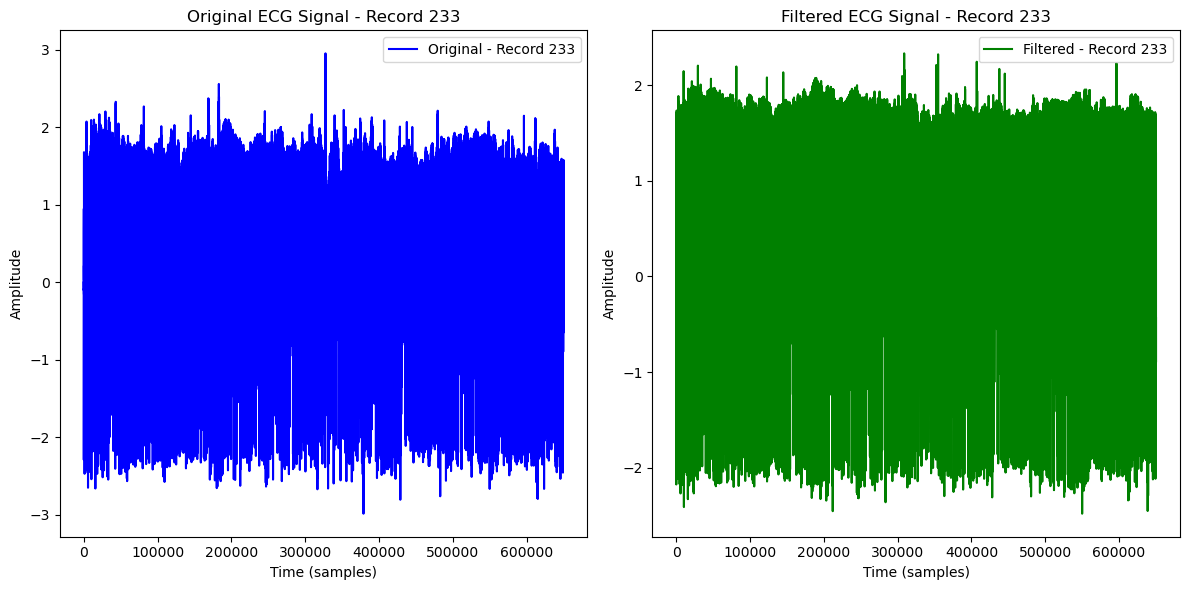

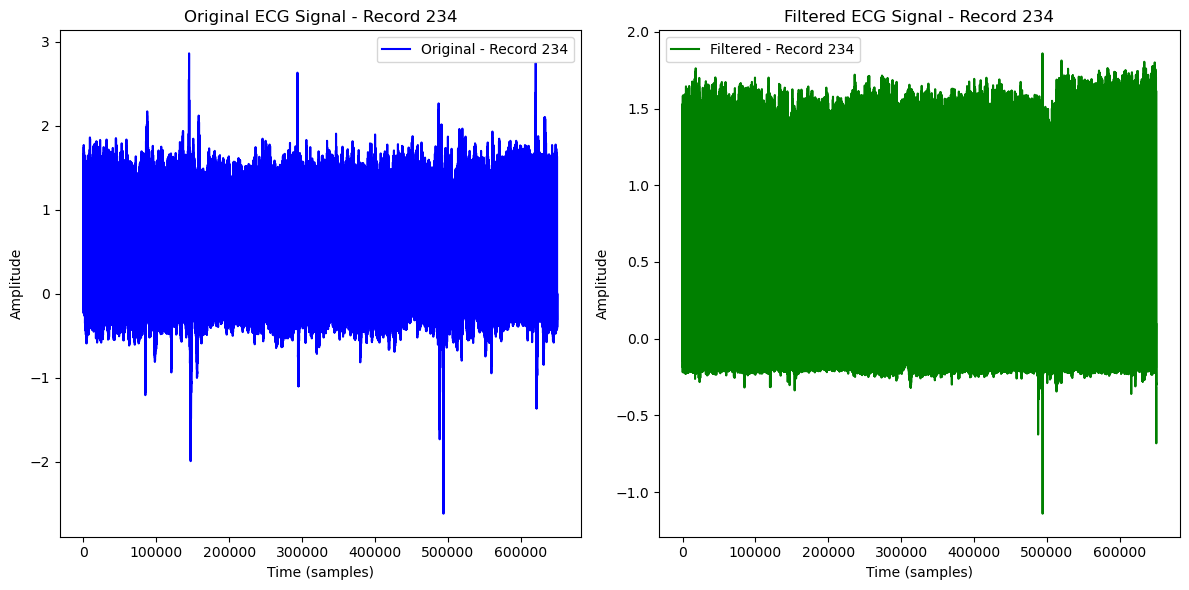

In [3]:
#Step 2 noise removal
import scipy.signal as signal
import matplotlib.pyplot as plt

# Function to apply a bandpass filter for noise removal
def remove_noise(ecg_signal, lowcut=0.5, highcut=50.0, sampling_rate=360):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Create a bandpass filter
    b, a = signal.butter(1, [low, high], btype='band')
    
    # Apply the filter to the ECG signal
    filtered_signal = signal.filtfilt(b, a, ecg_signal)
    
    return filtered_signal

# Process all records and remove noise with comparison plots
filtered_ecg_signals = {}  # Store filtered signals for all records

for record_file in record_files:
    record_name = record_file.replace('.dat', '')  # Remove the .dat extension
    record = wfdb.rdrecord(os.path.join(data_path, record_name))
    
    # Select Channel 1 (Lead II)
    ecg_signal = record.p_signal[:, 0]
    
    # Apply noise removal
    filtered_signal = remove_noise(ecg_signal)
    
    # Store the filtered signal
    filtered_ecg_signals[record_name] = filtered_signal
    
    # Plot original and filtered signals side by side
    plt.figure(figsize=(12, 6))

    # Subplot for original signal
    plt.subplot(1, 2, 1)
    plt.plot(ecg_signal, label=f'Original - Record {record_name}', color='blue')
    plt.title(f'Original ECG Signal - Record {record_name}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Subplot for filtered signal
    plt.subplot(1, 2, 2)
    plt.plot(filtered_signal, label=f'Filtered - Record {record_name}', color='green')
    plt.title(f'Filtered ECG Signal - Record {record_name}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


## Data Preprocessing: 

#### Data preparation: 

First step in preparation of data is **Normalization** which ensures that all data is on the same scale, reducing bias introduced by varying magnitudes across different records or signals. This is crucial when using feature extraction methods (like calculating maxima, minima, amplitudes, etc.), as different magnitudes can distort the extracted features. Therefore we normalized the signal using Min Max Scaling.

1. Window Segmentation: Sliding window technique involves moving the window along the time axis by a certain stride or step size (e.g., 1 second or 2 seconds). The window size selected was a 2 second cycle with half-window size(i.e 1 second ) overlap. This allowed to analyze shorter portions of the signal, which is typical in time-series analysis.

2. Local Maxima and Minima: Within each window segment, 'find\_peaks()' function was used to detect local maxima and minima. These represent the peaks and troughs of the ECG waveform, and their positions help calculate features like amplitude and intervals.

3. Amplitudes and Intervals: Amplitude is the difference between a peak and a trough, which gives insights into the signal's intensity. The intervals between consecutive maxima gave the time between heartbeats (R-R intervals).

4. R peaks : Since ECG analysis requires specific intervals and peaks (such as R-peak locations), features are calculated from the raw signal.

5. Heartbeat : Using the sample points provided in the annotation, heartbeat locations were identified.

6. RR Intervals: Calculated as the difference between consecutive R-peaks, the RR Intervals were computed for every window. 

7. Feature Engineering: Relevant features were extracted from the raw signals, focusing on physiological insights, such as peak amplitudes and interval measurements, especially in the ECG's Lead II, which is prominent for arrhythmia detection. Also, statistical metrics were calculated for segments of the signal (e.g., mean, median, standard deviation, skewness, kurtosis, local maxima and minima, heart rate, maximum frequency, Average PSD (The power spectral density (PSD) of the signal describes the power present in the signal as a function of frequency, per unit frequency)) for better feature representation.

8. Importing Rhythms : Table of Rhythms was used to input labels to the sliding windows of every record based on the consolidated duration of each label in the raw signals.


The below code defines a rhythm_table with rhythm durations, converting them to start and end times, and mapping them in rhythm_mapping.
The sliding_window function segments the ECG signals, and min_max_scale normalizes each window. For each window, basic statistics, local maxima and minima, heart rate, and frequency features are calculated. The final DataFrame, features_df, includes each record’s features and labels for use in further analysis or modeling.


In [4]:

# Rhythm table as a dictionary for demonstration purposes
rhythm_table = {
    '100': [('N', '30:06')],
    '101': [('N', '30:06')],
    '102': [('N', '1:22'), ('P', '28:44')],
    '103': [('N', '30:06')],
    '104': [('N', '3:52'), ('P', '26:13')],
    '105': [('N', '30:06')],
    '106': [('N', '22:36'), ('B', '7:15'), ('T', '0:13'), ('VT', '0:02')],
    '107': [('P', '30:06')],
    '108': [('N', '30:06')],
    '109': [('N', '30:06')],
    '111': [('N', '30:06')],
    '112': [('N', '30:06')],
    '113': [('N', '30:06')],
    '114': [('N', '30:01'), ('SVTA', '0:05')],
    '115': [('N', '30:06')],
    '116': [('N', '30:06')],
    '117': [('N', '30:06')],
    '118': [('N', '30:06')],
    '119': [('N', '22:36'), ('B', '3:55'), ('T', '3:34')],
    '121': [('N', '30:06')],
    '122': [('N', '30:06')],
    '123': [('N', '30:06')],
    '124': [('N', '28:36'), ('NOD', '0:30'), ('T', '0:22'), ('IVR', '0:37')],
    '200': [('N', '15:58'), ('B', '13:52'), ('VT', '0:15')],
    '201': [('N', '12:57'), ('SVTA', '0:02'), ('AFIB', '10:06'), ('NOD', '0:24'), ('T', '6:37')],
    '202': [('N', '19:31'), ('AFL', '0:48'), ('AFIB', '9:46')],
    '203': [('N', '2:43'), ('AFL', '5:14'), ('AFIB', '21:32'), ('T', '0:04'), ('VT', '0:33')],
    '205': [('N', '29:43'), ('VT', '0:23')],
    '207': [('N', '22:20'), ('SVTA', '0:52'), ('B', '2:38'), ('IVR', '1:49'), ('VT', '0:03'), ('VFL', '2:24')],
    '208': [('N', '24:43'), ('T', '5:22')],
    '209': [('N', '28:23'), ('SVTA', '1:42')],
    '210': [('AFIB', '29:30'), ('B', '0:23'), ('T', '0:07'), ('VT', '0:06')],
    '212': [('N', '30:06')],
    '213': [('N', '29:01'), ('B', '1:00'), ('VT', '0:04')],
    '214': [('N', '28:53'), ('T', '1:08'), ('VT', '0:05')],
    '215': [('N', '30:03'), ('VT', '0:02')],
    '217': [('AFIB', '4:12'), ('P', '25:10'), ('B', '0:42'), ('VT', '0:02')],
    '219': [('N', '6:01'), ('AFIB', '23:47'), ('B', '0:08'), ('T', '0:10')],
    '220': [('N', '29:50'), ('SVTA', '0:16')],
    '221': [('AFIB', '29:17'), ('B', '0:03'), ('T', '0:42'), ('VT', '0:04')],
    '222': [('N', '15:57'), ('AB', '1:28'), ('SVTA', '0:08'), ('AFL', '7:03'), ('AFIB', '1:44'), ('NOD', '3:45')],
    '223': [('N', '23:23'), ('B', '4:19'), ('T', '0:38'), ('VT', '1:46')],
    '228': [('N', '24:17'), ('B', '5:48')],
    '230': [('N', '17:45'), ('PREX', '12:21')],
    '231': [('N', '18:26'), ('BII', '11:40')],
    '232': [('SBR', '30:06')],
    '233': [('N', '28:03'), ('B', '1:48'), ('T', '0:04'), ('VT', '0:11')],
    '234': [('N', '29:40'), ('SVTA', '0:26')]
}

# Optimized sliding window function using NumPy
def sliding_window(signal, window_size, overlap):
    step = int(window_size * (1 - overlap))  # Calculate step size
    return np.lib.stride_tricks.sliding_window_view(signal, window_shape=window_size)[::step]

# Function to convert time strings to seconds
def convert_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '-':
        return 0
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Parse the rhythm table into a mapping of start and end times for each rhythm
def parse_rhythm_table(rhythm_table):
    record_rhythms = {}
    for record, rhythms in rhythm_table.items():
        record_rhythms[record] = []
        current_time = 0
        for rhythm_label, duration_str in rhythms:
            duration_seconds = convert_to_seconds(duration_str)
            end_time = current_time + duration_seconds
            record_rhythms[record].append((current_time, end_time, rhythm_label))
            current_time = end_time
    return record_rhythms

rhythm_mapping = parse_rhythm_table(rhythm_table)

# Function to get the label for a given time window
def get_rhythm_label(record_name, start_time, end_time, rhythm_mapping):
    if record_name not in rhythm_mapping:
        return None
    
    for rhythm_start, rhythm_end, rhythm_label in rhythm_mapping[record_name]:
        if start_time < rhythm_end and end_time > rhythm_start:
            return rhythm_label
    
    return None

# Function to perform Min-Max scaling
def min_max_scale(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val) if max_val > min_val else signal

# Main function to calculate features and assign labels
def calculate_features_for_all_records(record_list, dataset_dir, window_size, overlap, rhythm_mapping, fs=360):
    all_features = []
    
    for record_name in record_list:
        print(f"Processing record: {record_name}")
        record_path = os.path.join(dataset_dir, record_name)
        record = wfdb.rdrecord(record_path)
        ecg_windows = sliding_window(record.p_signal[:, 0], window_size, overlap)
        
        for i, window in enumerate(ecg_windows):
            start_time = i * int(window_size * (1 - overlap)) / fs
            end_time = start_time + window_size / fs
            
            # Use the rhythm_mapping to get the label
            label = get_rhythm_label(record_name, start_time, end_time, rhythm_mapping)
            
            # Apply Min-Max Scaling
            scaled_window = min_max_scale(window)
            
            # Calculate basic features from the scaled window
            minimum = np.min(scaled_window)
            maximum = np.max(scaled_window)
            std_dev = np.std(scaled_window)
            mean = np.mean(scaled_window)
            median = np.median(scaled_window)
            skewness = skew(scaled_window)
            kurt = kurtosis(scaled_window)

            # Find local maxima (R-peaks) and minima
            local_maxima_indices, _ = find_peaks(scaled_window, distance=fs//2)
            local_minima_indices, _ = find_peaks(-scaled_window, distance=fs//2)

            avg_local_max = np.mean(scaled_window[local_maxima_indices]) if local_maxima_indices.size > 0 else np.nan
            avg_local_min = np.mean(scaled_window[local_minima_indices]) if local_minima_indices.size > 0 else np.nan

            if local_maxima_indices.size > 0 and local_minima_indices.size > 0:
                max_amplitude = np.max(scaled_window[local_maxima_indices]) - np.min(scaled_window[local_minima_indices])
            else:
                max_amplitude = np.nan

            num_r_peaks = len(local_maxima_indices)
            heart_rate = (num_r_peaks / (window_size / fs)) * 60

            rr_intervals = np.diff(local_maxima_indices) / fs if len(local_maxima_indices) > 1 else [np.nan]
            avg_rr_interval = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan

            freqs, psd = welch(scaled_window, fs)
            max_freq = freqs[np.argmax(psd)]
            avg_psd = np.mean(psd)
            
            all_features.append([
                record_name, minimum, maximum, std_dev, mean, median, skewness, kurt,
                avg_local_max, avg_local_min, max_amplitude,
                heart_rate, avg_rr_interval, max_freq, avg_psd, label
            ])

    return pd.DataFrame(all_features, columns=[
        "Record", "Minimum", "Maximum", "StdDev", "Mean", "Median", "Skewness", "Kurtosis",
        "Avg_Local_Max", "Avg_Local_Min", "Amplitude", "HeartRate", "Avg_RR_Interval",
        "MaxFreq", "Avg_PSD", "Label"
    ])

# Calculate features with the updated rhythm mapping
features_df = calculate_features_for_all_records(list(rhythm_table.keys()), dataset_dir, window_size=360, overlap=0.5, rhythm_mapping=rhythm_mapping)

# Display the DataFrame with features and labels
features_df.head()

Processing record: 100
Processing record: 101
Processing record: 102
Processing record: 103
Processing record: 104
Processing record: 105
Processing record: 106
Processing record: 107
Processing record: 108
Processing record: 109
Processing record: 111
Processing record: 112
Processing record: 113
Processing record: 114
Processing record: 115
Processing record: 116
Processing record: 117
Processing record: 118
Processing record: 119
Processing record: 121
Processing record: 122
Processing record: 123
Processing record: 124
Processing record: 200
Processing record: 201
Processing record: 202
Processing record: 203
Processing record: 205
Processing record: 207
Processing record: 208
Processing record: 209
Processing record: 210
Processing record: 212
Processing record: 213
Processing record: 214
Processing record: 215
Processing record: 217
Processing record: 219
Processing record: 220
Processing record: 221
Processing record: 222
Processing record: 223
Processing record: 228
Processing 

Record  Minimum  Maximum    StdDev      Mean    Median  Skewness   Kurtosis  \
0    100      0.0      1.0  0.105222  0.170823  0.151852  5.203211  33.540753   
1    100      0.0      1.0  0.114738  0.152382  0.145763  5.097652  30.881576   
2    100      0.0      1.0  0.145764  0.163417  0.130719  4.180059  18.243906   
3    100      0.0      1.0  0.100912  0.155764  0.143791  5.867531  40.638532   
4    100      0.0      1.0  0.098314  0.199723  0.182724  5.621041  38.451895   

   Avg_Local_Max  Avg_Local_Min  Amplitude  HeartRate  Avg_RR_Interval  \
0       0.614815       0.062963   0.981481      120.0         0.641667   
1       0.571186       0.000000   1.000000      120.0         0.505556   
2       0.993464       0.031046   1.000000      120.0         0.813889   
3       0.607843       0.060458   1.000000      120.0         0.652778   
4       0.586379       0.069767   1.000000      120.0         0.580556   

   MaxFreq   Avg_PSD Label  
0  1.40625  0.000092     N  
1  5.62500  0.000068     N  
2  1.40625  0.000012     N  
3  7.03125  0.000193     N  
4  4.21875  0.000007     N

In [5]:
# Total number of rows in the DataFrame
total_rows = features_df.shape[0]
print(f"Total rows in the DataFrame: {total_rows}")


Total rows in the DataFrame: 173280


#### Data Cleaning: 

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming features_df is already defined as in your code

# 1. Data Cleaning: Check for null values
null_values = features_df.isnull().sum()
print("Null Values in Each Column:")
print(null_values[null_values > 0])


# 2. Checking unique values in the target variable 'Label'
unique_labels = features_df['Label'].unique()
print("\nUnique Labels in the 'Label' Column:")
print(unique_labels)


Null Values in Each Column:
Avg_Local_Min         1
Amplitude             1
Avg_RR_Interval    6403
dtype: int64

Unique Labels in the 'Label' Column:
['N' 'P' 'B' 'T' 'VT' 'SVTA' 'NOD' 'IVR' 'AFIB' 'AFL' 'VFL' 'AB' 'PREX'
 'BII' 'SBR']


The target column 'Label' contains 15 unique values ['N' 'P' 'B' 'T' 'VT' 'SVTA' 'NOD' 'IVR' 'AFIB' 'AFL' 'VFL' 'AB' 'PREX'
 'BII' 'SBR].
 '
There are 6403 null values in Avg_RR_Interval which is huge therefore we will be interpolating the value based on linear method..

To perform interpolation on the Avg_RR_Interval column, we can use pandas' interpolate() method. This method will fill missing values based on a specified interpolation technique, such as linear, polynomial, or spline. Given that physiological signals are often smooth, linear interpolation is a good option.

In [7]:
#Interpolation
# Performing linear interpolation on Avg_RR_Interval, Avg_Local_Min, and Amplitude columns
features_df['Avg_RR_Interval'] = features_df['Avg_RR_Interval'].interpolate(method='linear')
features_df['Avg_Local_Min'] = features_df['Avg_Local_Min'].interpolate(method='linear')
features_df['Amplitude'] = features_df['Amplitude'].interpolate(method='linear')

# Verifying if there are any remaining null values in these columns
print("Null values in Avg_RR_Interval:", features_df['Avg_RR_Interval'].isnull().sum())
print("Null values in Avg_Local_Min:", features_df['Avg_Local_Min'].isnull().sum())
print("Null values in Amplitude:", features_df['Amplitude'].isnull().sum())


Null values in Avg_RR_Interval: 0
Null values in Avg_Local_Min: 0
Null values in Amplitude: 0


In [8]:
# Display basic information about data types and null counts
print("Data Types and Null Counts:")
features_df.info()

# Display basic descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Columns:")
features_df.describe()

# If you have categorical columns and want to see their unique counts
print("\nUnique Counts for Columns:")
print(features_df.select_dtypes(include='object').nunique())


Data Types and Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173280 entries, 0 to 173279
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Record           173280 non-null  object 
 1   Minimum          173280 non-null  float64
 2   Maximum          173280 non-null  float64
 3   StdDev           173280 non-null  float64
 4   Mean             173280 non-null  float64
 5   Median           173280 non-null  float64
 6   Skewness         173280 non-null  float64
 7   Kurtosis         173280 non-null  float64
 8   Avg_Local_Max    173280 non-null  float64
 9   Avg_Local_Min    173280 non-null  float64
 10  Amplitude        173280 non-null  float64
 11  HeartRate        173280 non-null  float64
 12  Avg_RR_Interval  173280 non-null  float64
 13  MaxFreq          173280 non-null  float64
 14  Avg_PSD          173280 non-null  float64
 15  Label            173280 non-null  object 
dtypes: float64

#### Data distribution in Target-'Label' column

Label
N       126970
AFIB     15588
P        13222
B         5022
SBR       3610
T         2278
AFL       1570
PREX      1480
BII       1398
NOD        558
SVTA       416
VT         414
IVR        292
VFL        286
AB         176
Name: count, dtype: int64


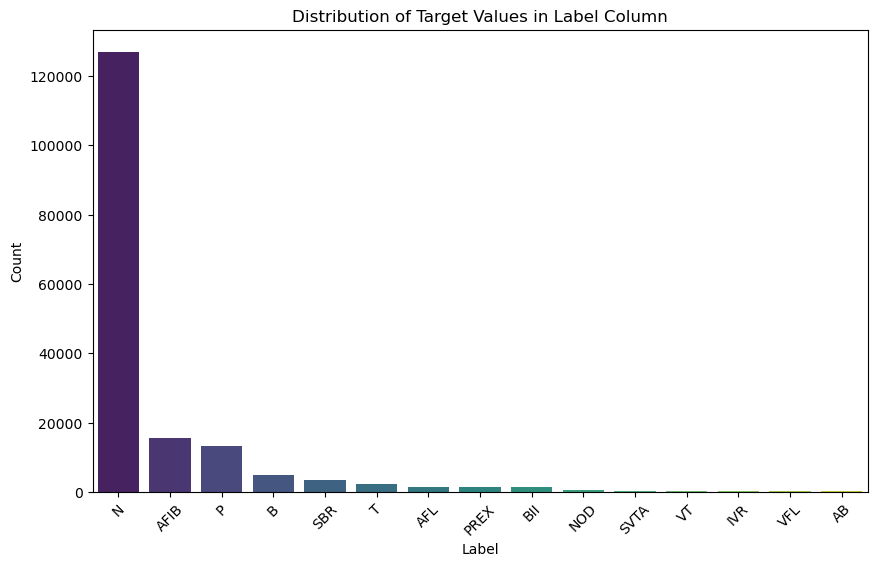

In [9]:
# Displaying the count of each unique value in the Label column
label_counts = features_df['Label'].value_counts()
print(label_counts)

# Plotting the distribution of target values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=features_df, x='Label', order=label_counts.index, palette="viridis")
plt.title('Distribution of Target Values in Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


From the distribution of data in the 'Label' column we understand that the percentage of 'N' is significantly higher than the rest. 

Since Minimum and Maximum columns are uniform, and 'Record' is a unique identifier across entire dataset we drop these columns. 

## Data Visualization: 

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Assuming ecg_windows is your segmented windows array
scaler = MinMaxScaler()
scaled_windows = scaler.fit_transform(ecg_windows)

# Choose a random window from the segmented ECG windows
random_window_idx = random.randint(0, len(scaled_windows) - 1)
random_window = scaled_windows[random_window_idx]


In [13]:
import random

# After defining and scaling your ECG windows
ecg_windows = sliding_window(ecg_signal, window_size, overlap)

# Scale the ECG windows if needed
scaler = MinMaxScaler()
scaled_windows = scaler.fit_transform(ecg_windows)

# Choose a random window from the segmented ECG windows
random_window_idx = random.randint(0, len(scaled_windows) - 1)
random_window = scaled_windows[random_window_idx]

# Continue with finding local maxima or any other processing


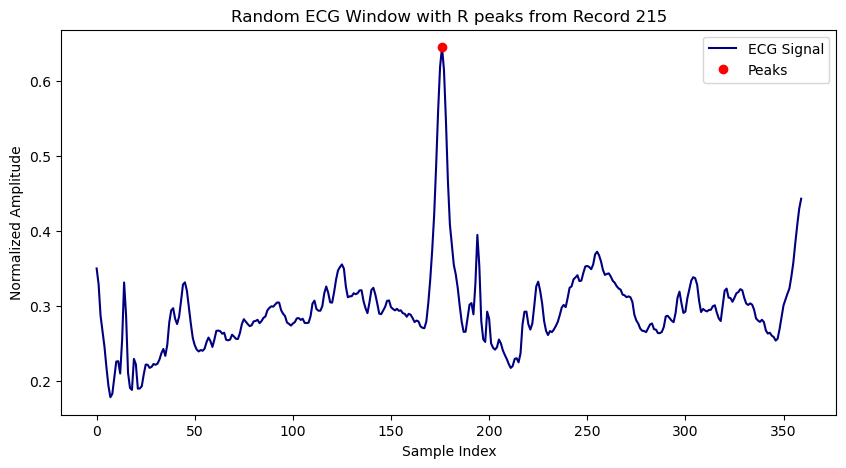

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.signal import find_peaks

# Select a random record and window
random_record = random.choice(list(rhythm_mapping.keys()))
record_path = os.path.join(dataset_dir, random_record)
record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]

# Parameters for windowing
window_size = 360  # 1-second window at 360 Hz
overlap = 0.5

# Use the sliding_window function to segment the ECG signal
ecg_windows = sliding_window(ecg_signal, window_size, overlap)

# Choose a random window from the segmented ECG windows
random_window_idx = random.randint(0, len(scaled_windows) - 1)
random_window = scaled_windows[random_window_idx]

# Find the local maxima (peaks) in the selected window
local_maxima_indices, _ = find_peaks(random_window, distance=180)  # Ensure sufficient distance between peaks

# Plot the window and the peaks
plt.figure(figsize=(10, 5))
plt.plot(random_window, label='ECG Signal', color='navy')
plt.plot(local_maxima_indices, random_window[local_maxima_indices], 'ro', label='Peaks')
plt.title(f"Random ECG Window with R peaks from Record {random_record}")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.show()


## Classification : 

Three models - Random Forest, SVM, Neural Networks have been used to classify the physiological signal rhythms into multiple classes. 

#### Label Encoding: 
Since tree based models are used, label encoding will be effective tool to encode the categorical target variable as these models can handle the integer representation directly without misinterpreting the values but Neural network would work better with One-hot encoding. Using one-hot encoding for Neural network will help ensure that our models treat the target classes appropriately without inferring any relationships that do not exist. This method enhances the model's ability to learn from the data accurately, especially in multi-class scenarios.

#### Data Splitting: 

The dataset was split into train, validation, and test sets in a 70:15:15 ratio using stratified sampling. This approach ensured that we have a dedicated validation set for model tuning and a final test set for evaluating generalization performance.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming `features_df` is your DataFrame
target_column = 'Label'  

# Features
X_rf = features_df.drop(columns=[target_column])  
X_rf = X_rf.drop(columns=['Record', 'Minimum', 'Maximum'])  # Ensure these columns exist
y_rf = features_df[target_column]  # Target

# Encode target labels if they're categorical
le = LabelEncoder()
y_rf = le.fit_transform(y_rf)
class_names = le.classes_  # Retrieve actual class labels for reference

# Split data into train (70%), validation (15%), and test (15%) sets
X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(
    X_rf, 
    y_rf, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_rf  # Use y_rf instead of y
)

X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(
    X_temp_rf, 
    y_temp_rf, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp_rf  # It’s also a good idea to stratify this
)

# At this point, you have:
# X_train_rf, y_train_rf for training
# X_val_rf, y_val_rf for validation
# X_test_rf, y_test_rf for testing


### Random Forest Classification: 

Random Forest is an ensemble learning method used for classification, regression, and other tasks, which operates by constructing multiple decision trees during training. For classification tasks, it aggregates the output of each tree to make a final decision based on majority voting, enhancing accuracy and reducing overfitting by relying on diverse models. 

Random Forest is used as one of the classification models to distinguish between different arrhythmia classes. After preprocessing the ECG data (including feature extraction, normalization, and peak detection), Random Forest model is used to learn patterns from these features, leveraging its robustness and ability to handle complex patterns in biomedical data. Performance was evaluated with accuracy, recall, and precision metrics, ensuring it captured relevant features across various ECG signals.

The workflow first splits and trains a base Random Forest model, then uses a validation set to evaluate initial performance. After optimizing with RandomizedSearchCV, the optimized model is evaluated on the test set for the final performance assessment. 

In [64]:
#Initial rf without optimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Evaluate on validation set
y_val_rf_pred = rf.predict(X_val_rf)

# Display validation results
print("Validation Set Metrics (Initial Random Forest):")
print("Accuracy:", accuracy_score(y_val_rf, y_val_rf_pred))
print("\nClassification Report:\n", classification_report(y_val_rf, y_val_rf_pred, target_names=class_names))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_val_rf, y_val_rf_pred)
cm_df_rf = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
display(cm_df_rf.style.set_caption("Confusion Matrix (Validation)\n Actual Vs Predicted \n Actuals=Rows, Predicted=Columns").background_gradient(cmap="Blues"))


Validation Set Metrics (Initial Random Forest):
Accuracy: 0.9049322868574946

Classification Report:
               precision    recall  f1-score   support

          AB       0.00      0.00      0.00        29
        AFIB       0.84      0.86      0.85      2299
         AFL       0.48      0.06      0.10       232
           B       0.65      0.21      0.32       751
         BII       0.64      0.51      0.57       202
         IVR       0.75      0.34      0.47        53
           N       0.92      0.97      0.94     19073
         NOD       0.68      0.34      0.46        67
           P       0.93      0.97      0.95      2009
        PREX       0.67      0.52      0.58       226
         SBR       1.00      0.98      0.99       555
        SVTA       0.00      0.00      0.00        61
           T       0.64      0.04      0.08       336
         VFL       0.94      0.71      0.81        41
          VT       0.00      0.00      0.00        58

    accuracy                    

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After the initial model training and validation, Random Forest demonstrated a validation accuracy of 90.49% when hyperparameters were used to perform Randomized search for model optimization to be able to increase the performance accuracy. 


#### Model Optimization: 

In [66]:
#hyper parameter optimization for rf
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized search
rf_optimized = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
rf_optimized.fit(X_train_rf, y_train_rf)

# Best parameters
print("Best Parameters from Optimization:", rf_optimized.best_params_)


Best Parameters from Optimization: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [67]:
# Train the optimized model
# Train the optimized model
rf_best = rf_optimized.best_estimator_

# Test on the test set
y_test_rf_pred = rf_best.predict(X_test_rf)

# Test results
print("Test Set Metrics (Optimized Random Forest):")
print("Accuracy:", accuracy_score(y_test_rf, y_test_rf_pred))
print("\nClassification Report:\n", classification_report(y_test_rf, y_test_rf_pred, target_names=class_names))

# Confusion Matrix
conf_matrix_test_rf = confusion_matrix(y_test_rf, y_test_rf_pred)
cm_test_df_rf = pd.DataFrame(conf_matrix_test_rf, index=class_names, columns=class_names)
display(cm_test_df_rf.style.set_caption("Confusion Matrix (Test)").background_gradient(cmap="Blues"))


Test Set Metrics (Optimized Random Forest):
Accuracy: 0.9060480147737765

Classification Report:
               precision    recall  f1-score   support

          AB       0.00      0.00      0.00        26
        AFIB       0.83      0.88      0.85      2334
         AFL       0.32      0.03      0.06       233
           B       0.67      0.24      0.35       770
         BII       0.70      0.50      0.58       221
         IVR       0.89      0.39      0.54        41
           N       0.92      0.97      0.95     19080
         NOD       0.80      0.26      0.39        92
           P       0.92      0.97      0.95      1923
        PREX       0.73      0.51      0.60       227
         SBR       1.00      0.98      0.99       537
        SVTA       0.00      0.00      0.00        52
           T       0.76      0.09      0.16       351
         VFL       1.00      0.76      0.86        42
          VT       0.00      0.00      0.00        63

    accuracy                        

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After the optimization, Random Forest showed a subtle improvement in the accuracy where it increased from 90.49% to 90.61%. 

Now we calculate the feature importance to drop least important features and train the model again. 

In [ ]:
#RF feature importance
import numpy as np

# Get feature importances from the best Random Forest model
importances = rf_best.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [69]:
# Set a threshold for dropping features
# For example, you might drop features with importance below 0.05
threshold = 0.00100
features_to_keep = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

# Create a new DataFrame with only the important features
X_rf_important = X_rf[features_to_keep]

# Split the new feature set into train, validation, and test sets again
X_train_rf_imp, X_temp_rf_imp, y_train_rf_imp, y_temp_rf_imp = train_test_split(X_rf_important, y_rf, test_size=0.3, random_state=42, stratify=y)
X_val_rf_imp, X_test_rf_imp, y_val_rf_imp, y_test_rf_imp = train_test_split(X_temp_rf_imp, y_temp_rf_imp, test_size=0.5, random_state=42, stratify=y)

print("\nFeatures kept after dropping least important features:")
print(features_to_keep)



Features kept after dropping least important features:
['Record', 'StdDev', 'Skewness', 'Kurtosis', 'Median', 'Mean', 'Avg_Local_Max', 'Avg_Local_Min', 'Avg_PSD', 'Avg_RR_Interval', 'MaxFreq', 'Amplitude', 'HeartRate']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model on the important features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf_imp, y_train_rf_imp)

# Evaluate the model on the validation set
y_val_pred_rf = rf_model.predict(X_val_rf_imp)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy_rf = accuracy_score(y_val_rf_imp, y_val_pred_rf)
precision_rf = precision_score(y_val_rf_imp, y_val_pred_rf, average='weighted')
recall_rf = recall_score(y_val_rf_imp, y_val_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_val_rf_imp, y_val_pred_rf)


In [82]:

print(f"Validation Accuracy (Random Forest): {accuracy_rf:.4f}")
print(f"Validation Precision (Random Forest): {precision_rf:.4f}")
print(f"Validation Recall (Random Forest): {recall_rf:.4f}")
cm_df_rf = pd.DataFrame(conf_matrix_rf, index=class_names, columns=class_names)
display(cm_df_rf.style.set_caption("Confusion Matrix (Test)").background_gradient(cmap="Blues"))


Validation Accuracy (Random Forest): 0.9049
Validation Precision (Random Forest): 0.8864
Validation Recall (Random Forest): 0.9049


In [ ]:
# Evaluate the model on the test set
# Initialize GridSearchCV
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_rf, y_train_rf)
# Get the best model
best_rf_model = grid_search_rf.best_estimator_


In [ ]:

y_test_pred_rf = best_rf_model.predict(X_test_rf)

# Calculate performance metrics on the test set
accuracy_test_rf = accuracy_score(y_test_rf_imp, y_test_pred_rf)
precision_test_rf = precision_score(y_test_rf_imp, y_test_pred_rf, average='weighted')
recall_test_rf = recall_score(y_test_rf_imp, y_test_pred_rf, average='weighted')
conf_matrix_test_rf = confusion_matrix(y_test_rf_imp, y_test_pred_rf)


In [81]:

print(f"Test Accuracy (Random Forest): {accuracy_test_rf:.4f}")
print(f"Test Precision (Random Forest): {precision_test_rf:.4f}")
print(f"Test Recall (Random Forest): {recall_test_rf:.4f}")
cm_test_df_rf = pd.DataFrame(conf_matrix_test_rf, index=class_names, columns=class_names)
display(cm_test_df_rf.style.set_caption("Confusion Matrix (Test)").background_gradient(cmap="Blues"))


Test Accuracy (Random Forest): 0.9045
Test Precision (Random Forest): 0.8893
Test Recall (Random Forest): 0.9045


#### Performance Evaluation : 

The optimization and feature selection for the Random Forest model on the MIT-BIH Arrhythmia dataset both showed high performance, with accuracy remaining relatively stable around 90.6% after optimization and slightly dropping to 90.45% after feature selection. Post-optimization, the Randomized Search CV yielded a test accuracy of 90.6%, with improved classification for certain arrhythmias, particularly normal beats (N) and premature ventricular complexes (P), which saw high recall and precision. However, minority classes like AB, AFL, and VT had poorer recall, indicating difficulty in classifying these underrepresented types even with optimization.

After feature selection, there was a slight reduction in overall accuracy (90.45%), and precision (88.93%), showing that feature reduction didn’t significantly affect model accuracy, but slightly impacted precision. The feature selection process may have removed some irrelevant or less impactful features, potentially streamlining the model without compromising general performance. These results suggest that while both optimization and feature selection maintain robust accuracy, optimization better addresses class imbalances.

Feature selection did not seem to be an effective approach in case of Arrhythmia classification using Random Forest as the accuracy did not improve significantly. There was an increase in the accuracy only with **Randomized Search Cross Validation.**


### Support Vector Machine

In [51]:
# SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd

# Assuming features_df and target_column are defined
target_column = 'Label'  # Make sure this matches your DataFrame's target column

# Features
X_svm = features_df.drop(columns=[target_column])  
X_svm = X_svm.drop(columns=['Record', 'Minimum', 'Maximum'])  # Ensure these columns exist

y_svm = features_df[target_column]  # Target

# Step 1: Split the data
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(
    X_svm, 
    y_svm, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_svm  # Use y_svm instead of y
)

X_val_svm, X_test_svm, y_val_svm, y_test_svm = train_test_split(
    X_temp_svm, 
    y_temp_svm, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp_svm  # Also stratify this split
)

# Step 2: Train the initial SVM model without optimization
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Step 3: Evaluate the model on the validation set
y_val_pred_svm = svm_model.predict(X_val_svm)

# Step 4: Calculate evaluation metrics
accuracy = accuracy_score(y_val_svm, y_val_pred_svm)
precision = precision_score(y_val_svm, y_val_pred_svm, average='weighted')  # Adjust average as needed
recall = recall_score(y_val_svm, y_val_pred_svm, average='weighted')  # Adjust average as needed
conf_matrix = confusion_matrix(y_val_svm, y_val_pred_svm)

# Print metrics
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", conf_matrix)


Validation Set Metrics:
Accuracy: 0.7327
Precision: 0.5369
Recall: 0.7327
Confusion Matrix:
 [[    0     0     0     0     0     0    27     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0  2338     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   236     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   753     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   209     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0    44     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0 19045     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0    83     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0  1984     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   222     0   

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Step 5: Predict on the test set
y_test_pred_svm = svm_model.predict(X_test_svm)

# Step 6: Calculate evaluation metrics for the test set
test_accuracy = accuracy_score(y_test_svm, y_test_pred_svm)
test_precision = precision_score(y_test_svm, y_test_pred_svm, average='weighted')  # Adjust average as needed
test_recall = recall_score(y_test_svm, y_test_pred_svm, average='weighted')  # Adjust average as needed
test_conf_matrix = confusion_matrix(y_test_svm, y_test_pred_svm)

# Print test metrics
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("Confusion Matrix:\n", test_conf_matrix)

Test Set Metrics:
Accuracy: 0.7328
Precision: 0.5369
Recall: 0.7328
Confusion Matrix:
 [[    0     0     0     0     0     0    26     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0  2338     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   235     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   754     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   210     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0    44     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0 19046     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0    84     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0  1983     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0   222     0     0   

C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The SVM model achieved a reasonable accuracy of 73.28%, but its low precision (53.69%) suggests a high rate of false positives, potentially due to class overlap or imbalance. Hyperparameter tuning was used to improve performance.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Feature scaling
scaler = StandardScaler()
X_svm_scaled = scaler.fit_transform(X_svm)

# Split the data again
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(X_svm_scaled, y_svm, test_size=0.3, random_state=42, stratify=y_svm)
X_val_svm, X_test_svm, y_val_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=42, stratify=y_temp_svm)

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # Only relevant for 'rbf' and 'poly'
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_svm, y_train_svm)

# Best parameters and estimator
print("Best parameters found: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# Fit the model on the combined training and validation set
best_svm_model.fit(X_train_full, y_train_full)

# Predict on the test set
y_test_pred_svm = best_svm_model.predict(X_test_svm)


After hyperparameter tuning the performance has improved significantly. With an accuracy improvement from 73% to 79% and precision and recall having significant improvement to 78.66% and 79.05% respectively, it is safe to say that Hyperparameter tuning has improved the performance of SVM model. 

### Neural Network Classification: 

In multiclass classification with neural networks, the goal is to classify input data into one of several categories. Neural networks achieve this through multiple layers of interconnected neurons that learn complex patterns in the data. For multiclass problems, one-hot encoding is often applied to the target labels to make them compatible with neural network architectures. 

With *one-hot encoding* , each category is represented by a binary vector where only the index corresponding to the target class is set to 1, and all others are 0. This transformation allows the neural network to treat each class distinctly and calculate probabilities for each class independently in the output layer, typically using a softmax activation function. Softmax normalizes the network outputs into a probability distribution across the classes, enabling clear predictions based on the highest probability score.

Neural network classifier was implemented on the MIT-BIH Arrhythmia dataset to identify various arrhythmia types. After encoding the labels with one-hot encoding, the network was trained with the processed time-series data, which had undergone feature extraction and normalization steps. The neural network learned to classify the data into multiple arrhythmia types based on patterns identified during training. The neural network’s parameters were optimized, including the number of neurons and layers, using randomized search and monitored its performance with metrics such as accuracy, precision, and recall. This approach allowed to evaluate how well the model distinguishes between different types of arrhythmias and where it may need further tuning, particularly for minority classes. The model showed strong performance in the majority classes, though challenges remained in accurately classifying less frequent arrhythmia types, emphasizing the need for continued optimization and data balancing strategies.

In [41]:
#Label encoding for neural network
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Step 1: Drop the 'Record' column
df = features_df.drop(columns=['Record'])

# Step 2: Encode the target variable 'Label'
df_encoded = pd.get_dummies(df, columns=['Label'], prefix='class')

# After encoding, prepare feature matrix (X) and target (y)
X = df_encoded.drop(columns=[col for col in df_encoded.columns if col.startswith('class_')])
y = df_encoded[[col for col in df_encoded.columns if col.startswith('class_')]]

In [42]:
#Data split
#Split the dataset into training, validation, and test sets (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y)

# Display shapes of the splits for confirmation
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training features shape: (121296, 14)
Training labels shape: (121296, 15)
Validation features shape: (25992, 14)
Validation labels shape: (25992, 15)
Testing features shape: (25992, 14)
Testing labels shape: (25992, 15)


In [ ]:
#Drop the least important features
X_train = X_train.drop(columns=['Minimum'])
X_val = X_val.drop(columns=['Minimum'])
X_test = X_test.drop(columns=['Minimum'])
X_train = X_train.drop(columns=['Maximum'])
X_val = X_val.drop(columns=['Maximum'])
X_test = X_test.drop(columns=['Maximum'])

In [47]:
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (121296, 12)
Training labels shape: (121296, 15)
Validation features shape: (25992, 12)
Validation labels shape: (25992, 15)
Testing features shape: (25992, 12)
Testing labels shape: (25992, 15)


In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy
import numpy as np

# Assuming X_train, X_val, y_train, y_val are defined as your train and validation sets
input_shape = X_train.shape[1]  # Number of features in the training data
num_classes = y_train.shape[1]  # Number of classes (for one-hot encoded targets)

# Step 1: Define your model
model = Sequential([
    Dense(units=64, activation='relu', input_shape=(input_shape,)),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

# Step 2: Compile the model with a loss function only (without optimization for actual training)
model.compile(loss=CategoricalCrossentropy(), metrics=[Accuracy()])



C:\Users\shiva\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
# Step 4: Re-compile the model with an optimizer for training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Fit the model on the training data with EarlyStopping on validation set
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])



Epoch 1/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7232 - loss: 1.3055 - val_accuracy: 0.7353 - val_loss: 1.0032
Epoch 2/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7377 - loss: 0.9966 - val_accuracy: 0.7463 - val_loss: 0.9448
Epoch 3/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7395 - loss: 0.9349 - val_accuracy: 0.7514 - val_loss: 0.8945
Epoch 4/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7430 - loss: 0.9025 - val_accuracy: 0.7480 - val_loss: 0.8713
Epoch 5/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7474 - loss: 0.8804 - val_accuracy: 0.7501 - val_loss: 0.8623
Epoch 6/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7531 - loss: 0.8525 - val_accuracy: 0.7583 - val_loss: 0.8279
Epoch 7/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7517 - loss: 0.8456 - val_accuracy: 0.7611 - val_loss: 0.8334
Epoch 8/20
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7553 - loss: 0.82

The model performed significantly lower than expected even with optimization resulting in a validation accuracy of 77.67%. 

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import numpy as np
import pandas as pd

# Assuming the model is already trained with training data (X_train, y_train) and validated on (X_val, y_val)

# Step 1: Make predictions on the test set
y_test_pred_probs = model.predict(X_test)  # Get probabilities
y_test_pred = np.argmax(y_test_pred_probs, axis=1)  # Convert probabilities to class predictions

# Step 2: Convert y_test back to label format if it's one-hot encoded
y_test_labels = np.argmax(y_test, axis=1)

# Step 3: Compute Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test_labels, y_test_pred)
class_report = classification_report(y_test_labels, y_test_pred, target_names=class_names)

# Step 4: Calculate Overall Metrics
overall_accuracy = accuracy_score(y_test_labels, y_test_pred)
overall_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
overall_recall = recall_score(y_test_labels, y_test_pred, average='weighted')

813/813 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shiva\anaconda3\Lib\site-packages\sklearn\metr

In [62]:
# Define class names for display purposes
class_names = [col.replace('class_', '') for col in y.columns]

# Display results
print("Confusion Matrix:\n", pd.DataFrame(conf_matrix, index=class_names, columns=class_names))
print("\nClassification Report:\n", class_report)
print("\nOverall Accuracy: {:.4f}".format(overall_accuracy))
print("Overall Precision: {:.4f}".format(overall_precision))
print("Overall Recall: {:.4f}".format(overall_recall))


Confusion Matrix:
       AB  AFIB  AFL  B  BII  IVR      N  NOD     P  PREX  SBR  SVTA  T  VFL  \
AB     0     0    0  0    0    0     24    0     2     0    0     0  0    0   
AFIB   0   354    2  2    1    0   1893    0    75     2    5     0  0    0   
AFL    0     3    0  0    0    0    204    0    22     0    4     0  0    0   
B      0    21    0  2    0    0    718    0    25     0    2     0  0    2   
BII    0     0    0  0   95    0    124    0     0     1    1     0  0    0   
IVR    0     0    0  0    0    5     32    0     4     0    0     0  0    0   
N      0   266    0  5   79   10  18384    0   282    29   23     0  0    2   
NOD    0     0    0  0    0    0     90    0     2     0    0     0  0    0   
P      0    10    0  0    2    0    835    0  1062     0   14     0  0    0   
PREX   0     1    0  0    0    0    188    0     0    38    0     0  0    0   
SBR    0     0    0  0    4    1    310    0    27     0  195     0  0    0   
SVTA   0     1    0  0    0    0 

Using early stopping stops training when the model stops improving, which can save time and prevent overfitting.

The results of Neural Network on the test set show that the neural network classifier achieved an overall test accuracy of 77.47%, with precision and recall scores of 71.12% and 77.47%, respectively. However, the confusion matrix and classification report reveal mixed performance across different arrhythmia classes. Notably, the classifier performed well on the majority class (N), achieving a recall of 96% and an F1-score of 87%, indicating that the model learned the predominant patterns in this class. Additionally, other classes like P, BII, and SBR showed moderate precision and recall, suggesting some success in identifying these arrhythmias but with significant misclassifications into the more frequent classes.

In contrast, the model struggled with minority classes such as AB, AFIB, AFL, NOD, SVTA, and VT, with extremely low or zero precision and recall for these classes. This result indicates that the neural network’s ability to capture the unique characteristics of these classes was limited, possibly due to class imbalance in the dataset and insufficient distinguishing features for rare arrhythmias. While the neural network can capture patterns for common arrhythmia types, it may need further optimization, such as implementing balanced training strategies or employing ensemble models, to improve recognition of underrepresented arrhythmia classes.